# Evaluación 1 - Entrenando redes feedforward

**Autor:**

+ Angelo López

**Correo Electrónico:**

+ an.lopezq@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.1  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

# Introducción

## Descripción del Problema y Objetivos

El reconocimiento y clasificación de dígitos escritos a mano constituye una tarea fundamental dentro del ámbito del reconocimiento de patrones, con aplicaciones prácticas en diversas áreas como procesamiento automático de documentos, reconocimiento óptico de caracteres (**OCR**) y seguridad informática. El conjunto de datos **MNIST** (Modified National Institute of Standards and Technology) es un estándar ampliamente reconocido que contiene 70,000 imágenes en escala de grises (28x28 píxeles), etiquetadas con dígitos del 0 al 9, y es utilizado como referencia para evaluar algoritmos de aprendizaje automático.

Este proyecto tiene como objetivo comparar empíricamente el rendimiento de dos algoritmos de optimización ampliamente utilizados en Deep Learning: **Adam** y **Adamax**, aplicados a un modelo **MLP** entrenado sobre el dataset **MNIST**. A través de la experimentación controlada, se busca evaluar cuál de estos optimizadores logra una mejor precisión y estabilidad durante el entrenamiento y pruebas, en el contexto de una tarea de clasificación multiclase.


## Justificación del Enfoque


El estudio de distintos algoritmos de optimización es fundamental en el diseño de redes neuronales artificiales, ya que influyen directamente en la velocidad de convergencia, la estabilidad del aprendizaje y el rendimiento final del modelo. **Adam** es uno de los optimizadores más populares por su balance entre velocidad y precisión, mientras que **Adamax**, una variante basada en normas infinitas, puede ofrecer ventajas en ciertos contextos. Este proyecto propone un análisis comparativo entre ambos, utilizando la misma arquitectura de red y los mismos datos, variando únicamente el optimizador para garantizar condiciones experimentales justas.

# Carga de datos

En este proyecto, el dataset MNIST se carga directamente desde archivos en formato IDX comprimidos (archivos .gz) alojados externamente.

Para ello se utilizan ciertas ténicas para cargar los datos como:
- Eliminación previa (`!rm -f`):
Asegura que cualquier versión anterior o archivos parcialmente descargados sean eliminados, previniendo problemas de consistencia o conflictos al momento de cargar los datos.

- Descarga de archivos (`!wget`):
Garantiza que los archivos se obtengan directamente desde la fuente oficial, asegurando así integridad y confiabilidad de los datos utilizados en el proyecto.

In [41]:
# Eliminar archivos anteriores (si existen) para evitar conflictos
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

# Descargar archivos del dataset MNIST
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz

--2025-04-20 18:44:29--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.123, 172.217.15.251, 172.217.164.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  51.9MB/s    in 0.2s    

2025-04-20 18:44:29 (51.9 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-20 18:44:29--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.123, 172.217.15.251, 172.217.164.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [applica

**Verificación de los archivos descargados (`!ls -lh`)**: Esta línea se ejecuta para listar los archivos descargados, indicando su tamaño. Esto permite verificar visualmente que la descarga se realizó correctamente y que el tamaño del archivo coincide aproximadamente con lo esperado.

In [42]:
!ls -lh

total 12M
drwxr-xr-x 1 root root 4.0K Apr 17 13:36 sample_data
-rw-r--r-- 1 root root 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [109]:
import os
import gzip
import shutil
import struct
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from IPython.display import Markdown, display
from tensorflow.keras import Input, layers, models, optimizers, losses
from tensorflow import keras

# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

# Carga de imágenes

* `load_mnist_images(filename)`:
Esta función abre el archivo de imágenes MNIST indicado (en formato IDX comprimido). Utiliza `gzip.open` para leer los datos comprimidos y luego los extrae en un arreglo NumPy. Con el argumento `offset=16`, se saltan los primeros 16 bytes del encabezado del archivo, que contienen información sobre el dataset (formato interno). Luego, las imágenes son reestructuradas (`reshape`) a vectores planos de tamaño 784 (28x28 píxeles) y normalizadas al rango [0,1], dividiendo entre 255. Esto mejora la eficiencia y estabilidad del entrenamiento de redes neuronales.

* `load_mnist_labels(filename)`:
Esta función lee las etiquetas correspondientes a las imágenes desde su respectivo archivo comprimido. Similarmente, utiliza `gzip.open` y NumPy con `offset=8`, omitiendo los primeros 8 bytes del encabezado (información interna sobre el dataset). Luego convierte estas etiquetas en formato one-hot encoding utilizando `keras.utils.to_categorical`, necesario para la clasificación multiclase con redes neuronales.

In [4]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


Ambas funciones son usadas para cargar los conjuntos de entrenamiento y prueba, asegurando que los datos queden correctamente preparados:

- `X_train`, `X_test` contienen las imágenes en formato vectorial, listas para la entrada al modelo MLP.

- `y_train`, `y_test` contienen las etiquetas codificadas adecuadamente para la tarea de clasificación.

La impresión final permite verificar rápidamente que las dimensiones de los conjuntos cargados sean correctas y coincidan con lo esperado:

- Entrenamiento: 60,000 muestras (imágenes de 784 píxeles), cada una con su etiqueta en formato one-hot de 10 categorías.

- Prueba: 10,000 muestras para evaluar el modelo.


Finalmente se genera la visualización del dataset de **MNIST**:

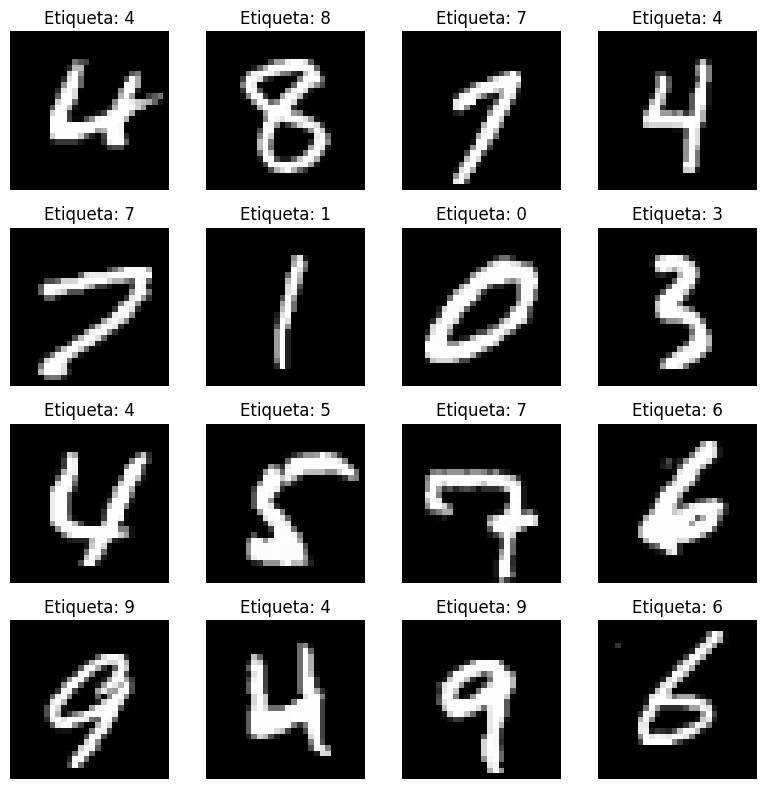

In [5]:
# Tamaño de la grilla
h = 4  # filas
w = 4  # columnas

# Crear la figura
fig, axs = plt.subplots(h, w, figsize=(2 * w, 2 * h))

# Mostrar imágenes aleatorias del conjunto de entrenamiento
for i in range(h):
    for j in range(w):
        ex = np.random.randint(len(X_train))
        img = X_train[ex].reshape(28, 28)  # reformatear imagen plana a 28x28
        label = np.argmax(y_train[ex])     # recuperar la etiqueta original desde one-hot

        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(f"Etiqueta: {label}")
        axs[i, j].axis('off')  # quitar ejes para mayor claridad visual

plt.tight_layout()
plt.show()


# Definición del Experimento

El experimento se ha diseñado para cuantificar y comparar el rendimiento de dos algoritmos de optimización: Adam y Adamax, aplicados a una misma arquitectura de red neuronal multicapa (MLP) entrenada sobre el conjunto de datos MNIST. El objetivo principal es evaluar cómo cada optimizador influye en la velocidad de convergencia y en la capacidad de generalización del modelo, usando como métrica central la accuracy en el conjunto de validación.

Para asegurar un análisis riguroso, se estableció un ensayo controlado en el cual solo se modifica una variable a la vez, manteniendo constantes las demás. La secuencia de experimentos incluye:

|Experimento | Épocas | Batch Size | Dropout | Capas Ocultas | Neuronas por Capa | Func. Activación | Func. Salida | Func. Pérdida | Learning Rate |
|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------| -----------| -----------|
Baseline | 10 | 32 | 0.35 | 2 | [256, 128] | relu	| softmax | CategoricalCrossentropy | 0.001
V1 – Épocas | 20 | 32 | 0.35 | 2 | [256, 128] | relu	| softmax | CategoricalCrossentropy | 0.001
V2 – Batch | 10 | 64 | 0.35 | 2 | [256, 128] | relu	| softmax | CategoricalCrossentropy | 0.001
V3 – Drop | 10 | 32 | 0.5 | 2 | [256, 128] | relu	| softmax | CategoricalCrossentropy | 0.001
V4 – Capas	 | 10 | 32 | 0.35 | 3 | [256, 128, 64] | relu	| softmax | CategoricalCrossentropy | 0.001
V5 – Neur.	 | 10 | 32 | 0.35 | 2 | [512, 256] | relu	| softmax | CategoricalCrossentropy | 0.001
V6 – Act.	 | 10 | 32 | 0.35 | 2 | [256, 128] | sigmoid	| softmax | CategoricalCrossentropy | 0.001
V7 – Sal.	 | 10 | 32 | 0.35 | 2 | [256, 128] | relu	| sigmoid | CategoricalCrossentropy | 0.001
V8 – Loss	 | 10 | 32 | 0.35 | 2 | [256, 128] | relu	| softmax | CategoricalFocalCrossentropy | 0.001
V9 – LR	 | 10 | 32 | 0.35 | 2 | [256, 128] | relu	| softmax | CategoricalCrossentropy | 0.0001




1. **Línea Base (Baseline):**

  - Arquitectura MLP con dos capas ocultas de 256 y 128 neuronas, tasa de aprendizaje inicial de 0.001, batch size de 32, dropout de 0.35, y 10 épocas de entrenamiento. Se ejecuta por separado con Adam y con Adamax para obtener el punto de partida.

2. **Variantes de Configuraciones**:

  - Variante 1 – 9: Cada variante se aplica en dos ejecuciones paralelas: una con Adam y otra con Adamax. Con ello, se aíslan los efectos de cada parámetro tanto en la rapidez con la que se alcanza un cierto umbral de accuracy como en el pico máximo de precisión obtenido, entre otros.

Las variables de respuesta serán registradas en todos los experimentos y corresponden a las métricas de rendimiento (accuracy, precision, recall y F1-score), capturadas por época tanto en entrenamiento como en validación. La comparación de las curvas de accuracy vs. época y loss vs. época permite visualizar directamente la estabilidad y velocidad de convergencia de cada optimizador bajo condiciones controladas.


# Desarrollo del Experimento

## Baseline

Retomando lo definido en la sección anterior, en esta fase se implementa el **Baseline** para ambos optimizadores (Adam y Adamax) de forma manual, sin abstraer todavía la lógica en una función genérica. Esta decisión se tomó por **cuestiones de tiempo**: al inicio del proyecto resultó más ágil copiar y adaptar el bloque de creación y entrenamiento para cada optimizador desde el material académico, evitando dedicar horas a la refactorización antes de validar que la arquitectura básica funcionara correctamente.

### Adam

Se define explícitamente la **arquitectura MLP**: dos capas densas de 256 y 128 neuronas con activación ReLU, separadas por capas de dropout al 35 %. Esta configuración busca un equilibrio entre capacidad de aprendizaje y regularización, permitiendo que la red capture patrones complejos sin sobreajustar los datos de entrenamiento. Las capas densas proporcionan la profundidad necesaria para modelar relaciones no lineales, mientras que el dropout introduce ruido controlado para mejorar la generalización.



In [65]:
# Cantidad de ejemplos y dimensiones I/O
M_train = X_train.shape[0]
M_test  = X_test.shape[0]
N       = X_train.shape[1]
C       = y_train.shape[1]
print(f"N={N}, C={C}, M_train={M_train}, M_test={M_test}")

# Hiperparámetros del Baseline
h1, h2         = 256, 128        # Neuronas en capas ocultas
dropout_rate   = 0.35            # Dropout para regularización
epochs, batch  = 10, 32          # Épocas y tamaño de batch
learning_rate  = 0.001           # Tasa de aprendizaje por defecto

N=784, C=10, M_train=60000, M_test=10000


A continuación, el modelo se **compila** seleccionando el optimizador **Adam** (con tasa de aprendizaje 0.001) y la función de pérdida `categorical_crossentropy`, acorde a un problema de clasificación multiclase. Adam combina las ventajas del momento adaptativo y de la normalización de gradientes, ofreciendo una convergencia rápida y estable. Además, se registran las métricas de interés para disponer de información detallada sobre diferentes facetas del desempeño durante el entrenamiento.


In [66]:
# Semillas para reproducibilidad
np.random.seed(29)
tf.random.set_seed(29)

# Entrena el baseline con Adam
red_adam = keras.Sequential(name="Baseline_Adam")
red_adam.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam.add(keras.layers.Dense(h1, activation='relu', name="hidden1"))
red_adam.add(keras.layers.Dropout(0.35))
red_adam.add(keras.layers.Dense(h2, activation='relu', name="hidden2"))
red_adam.add(keras.layers.Dropout(0.35))
red_adam.add(keras.layers.Dense(C, activation='softmax', name="salida"))

red_adam.summary()

red_adam.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy", "Precision", "Recall", tf.keras.metrics.F1Score(name="f1_score")]
)

Model: "Baseline_Adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Finalmente, al **entrenar** con `model.fit(..., validation_data=(X_test, y_test))`, se ejecuta el proceso de ajuste de pesos durante 10 épocas con batches de 32 ejemplos. Este enfoque permite:
1. **Monitorear** la evolución de las métricas tanto en entrenamiento como en validación.
2. **Detectar rápidamente** señales de overfitting (si la pérdida de validación comienza a subir) o underfitting (si la accuracy permanece baja).
3. **Registrar** los historiales en `hist_adam` para su posterior análisis comparativo.


In [67]:
hist_adam = red_adam.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - Precision: 0.9122 - Recall: 0.7643 - accuracy: 0.8347 - f1_score: 0.8304 - loss: 0.5341 - val_Precision: 0.9730 - val_Recall: 0.9548 - val_accuracy: 0.9648 - val_f1_score: 0.9645 - val_loss: 0.1220
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9596 - Recall: 0.9393 - accuracy: 0.9490 - f1_score: 0.9484 - loss: 0.1712 - val_Precision: 0.9743 - val_Recall: 0.9654 - val_accuracy: 0.9697 - val_f1_score: 0.9695 - val_loss: 0.0985
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - Precision: 0.9660 - Recall: 0.9515 - accuracy: 0.9583 - f1_score: 0.9578 - loss: 0.1352 - val_Precision: 0.9751 - val_Recall: 0.9668 - val_accuracy: 0.9713 - val_f1_score: 0.9710 - val_loss: 0.0921
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.9716 - Recall: 0.9596 - accuracy: 0.9650 - f1_score: 0.9646 - loss: 0.1132 - val_Precision: 0.9810 - val_Recall: 0.9743 - val_accuracy: 0.9777 - val_f1_score: 0.9775

### Adamax

Aquí se replica el mismo **MLP baseline**: dos capas densas de 256 y 128 neuronas con dropout al 35 % pero se sustituye el optimizador por **Adamax**, una variante que utiliza la norma infinita de los gradientes y puede ofrecer mayor estabilidad en presencia de gradientes dispersos.

In [69]:
# redefinimos semillas para que redes sean comparables
np.random.seed(29)
tf.random.set_seed(29)

red_adamax = keras.Sequential(name="Baseline_Adamax")
red_adamax.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adamax.add(keras.layers.Dense(h1, activation='relu', name="hidden1"))
red_adamax.add(keras.layers.Dropout(0.35))
red_adamax.add(keras.layers.Dense(h2, activation='relu', name="hidden2"))
red_adamax.add(keras.layers.Dropout(0.35))
red_adamax.add(keras.layers.Dense(C, activation='softmax', name="salida"))

red_adamax.summary()

# Compilación con Adamax
red_adamax.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adamax(learning_rate=learning_rate),
    metrics=["accuracy", "Precision", "Recall", tf.keras.metrics.F1Score(name="f1_score")]
)

Model: "Baseline_Adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Al compilar con `optimizer=keras.optimizers.Adamax(learning_rate=0.001)`, se mantiene la tasa de aprendizaje inicial y la función de pérdida `categorical_crossentropy`, garantizando una comparación directa con Adam. Durante el entrenamiento (10 épocas, batch size = 32), se registran las mismas métricas clave (accuracy, precision, recall y F1-score) y se almacena el historial en `hist_adamax`.

In [70]:
hist_adamax = red_adamax.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.9009 - Recall: 0.6533 - accuracy: 0.7799 - f1_score: 0.7744 - loss: 0.7179 - val_Precision: 0.9545 - val_Recall: 0.9302 - val_accuracy: 0.9402 - val_f1_score: 0.9394 - val_loss: 0.1951
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9462 - Recall: 0.9078 - accuracy: 0.9254 - f1_score: 0.9242 - loss: 0.2516 - val_Precision: 0.9644 - val_Recall: 0.9481 - val_accuracy: 0.9551 - val_f1_score: 0.9547 - val_loss: 0.1398
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.9574 - Recall: 0.9323 - accuracy: 0.9439 - f1_score: 0.9432 - loss: 0.1873 - val_Precision: 0.9707 - val_Recall: 0.9599 - val_accuracy: 0.9654 - val_f1_score: 0.9651 - val_loss: 0.1121
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - Precision: 0.9652 - Recall: 0.9452 - accuracy: 0.9547 - f1_score: 0.9542 - loss: 0.1545 - val_Precision: 0.9727 - val_Recall: 0.9649 - val_accuracy: 0.9681 - val_f1_score: 0.9679

### Comparativa Baseline

Este bloque permite contrastar la **convergencia** de Adamax frente a Adam según Accuracy y Loss bajo condiciones idénticas, aportando así datos concretos sobre su desempeño relativo en la tarea de clasificación de dígitos.

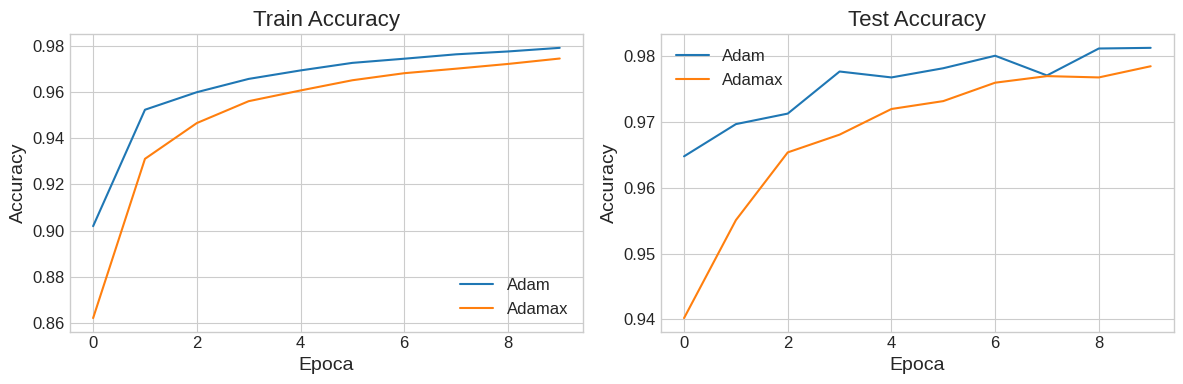

In [71]:
# Grilla para Accuracy: Train vs Test
fig_acc, axes_acc = plt.subplots(1, 2, figsize=(12, 4))

# Train Accuracy
axes_acc[0].plot(hist_adam.history['accuracy'], label='Adam')
axes_acc[0].plot(hist_adamax.history['accuracy'], label='Adamax')
axes_acc[0].set_title('Train Accuracy')
axes_acc[0].set_xlabel('Epoca')
axes_acc[0].set_ylabel('Accuracy')
axes_acc[0].legend()

# Test Accuracy
axes_acc[1].plot(hist_adam.history['val_accuracy'], label='Adam')
axes_acc[1].plot(hist_adamax.history['val_accuracy'], label='Adamax')
axes_acc[1].set_title('Test Accuracy')
axes_acc[1].set_xlabel('Epoca')
axes_acc[1].set_ylabel('Accuracy')
axes_acc[1].legend()

plt.tight_layout()
plt.show()

En entrenamiento, Adam arranca cerca de 90 % de accuracy en la época 0 y supera el 95 % en la época 1, para estabilizarse alrededor del 98 % al término de la época 9; Adamax, en cambio, inicia en torno al 86 %, alcanza el 93 % en la época 1 y remata cerca del 97.5 %. En el conjunto de prueba, Adam parte en aproximadamente 96.5 % y culmina en torno al 98.1 %, mientras que Adamax comienza en el 94 % y finaliza cerca del 97.8 %. Estas curvas evidencian que Adam logra tanto una convergencia más rápida como un pico máximo ligeramente superior frente a Adamax.

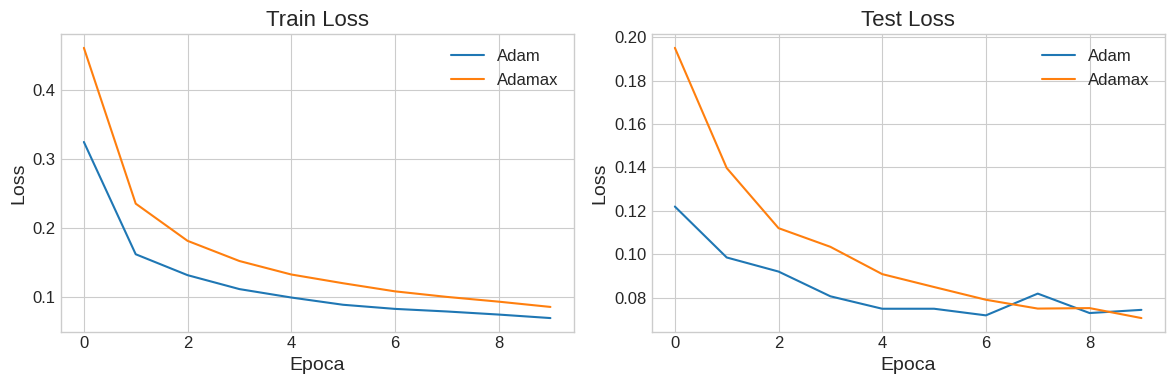

In [72]:
# Grilla para Loss: Train vs Test
fig_loss, axes_loss = plt.subplots(1, 2, figsize=(12, 4))

# Train Loss
axes_loss[0].plot(hist_adam.history['loss'], label='Adam')
axes_loss[0].plot(hist_adamax.history['loss'], label='Adamax')
axes_loss[0].set_title('Train Loss')
axes_loss[0].set_xlabel('Epoca')
axes_loss[0].set_ylabel('Loss')
axes_loss[0].legend()

# Test Loss
axes_loss[1].plot(hist_adam.history['val_loss'], label='Adam')
axes_loss[1].plot(hist_adamax.history['val_loss'], label='Adamax')
axes_loss[1].set_title('Test Loss')
axes_loss[1].set_xlabel('Epoca')
axes_loss[1].set_ylabel('Loss')
axes_loss[1].legend()

plt.tight_layout()
plt.show()

Para el loss de entrenamiento, Adam disminuye de unos 0.32 en la época 0 a aproximadamente 0.07 en la época 9, mientras que Adamax cae de alrededor de 0.46 a 0.09 en el mismo intervalo. En validación, Adam reduce su loss de ~0.12 a ~0.075, y Adamax de ~0.19 a ~0.075 también, aunque con una pendiente inicial menos pronunciada. Esto muestra que Adam no solo minimiza el error más rápidamente durante el entrenamiento, sino que también lo mantiene ligeramente por debajo de Adamax en las primeras épocas, reflejando una convergencia más eficiente y estable.

## Variantes de Configuración

A partir del **Baseline** definido y evaluado previamente, el análisis experimental avanza mediante un esquema iterativo de “un cambio a la vez”. Cada variante modifica únicamente un hiperparámetro, preservando intactos el resto de los elementos de la red y los criterios de entrenamiento. Este enfoque garantiza que cualquier diferencia en los resultados se atribuya de forma inequívoca al hiperparámetro bajo estudio.

Así, en **V1** se duplica el número de épocas para medir el efecto de un entrenamiento más prolongado sobre la convergencia y el pico de accuracy; en **V2** se incrementa el tamaño de batch de 32 a 64 para examinar la influencia de la granularidad del gradiente; en **V3** se eleva la tasa de dropout de 0.35 a 0.50 explorando su capacidad para combatir el sobreajuste; en **V4** se añade una capa oculta adicional para valorar el impacto de la profundidad arquitectónica; y en **V9** se reduce la learning rate a 0.0001 para observar cómo una actualización de pesos más fina afecta la estabilidad del descenso de la función de pérdida.

Cada una de estas variantes se ejecuta tanto con Adam como con Adamax, alimentando los historiales de training y validation que luego se consolidan en tablas y gráficos comparativos. De este modo, se recorre paso a paso el diseño experimental: conoce la motivación de cada cambio, ve su implementación concreta en código y, finalmente, analiza sus efectos cuantitativos, construyendo una visión integral de cómo los hiperparámetros inciden en la eficiencia y robustez de la red.









### Generación de Modelo

**Definición y propósito de la función `crear_y_entrenar_modelo()`**:

- La función `crear_y_entrenar_modelo()` abstrae en un único bloque de código todo el flujo de creación, compilación y entrenamiento de un modelo MLP, garantizando **reproducibilidad**, **modularidad** y **control experimental**. A continuación se describen sus componentes y su importancia:

   ```python
   def crear_y_entrenar_modelo(
       nombre: str,
       optimizer: str,
       epocas: int,
       batch_size: int,
       dropout: float,
       capas_ocultas: list[int],
       activacion: str = 'relu',
       activacion_salida: str = 'softmax',
       funcion_perdida: Union[str, Loss] = 'categorical_crossentropy',
       learning_rate: float = 0.001
   )


**Parámetros**

- **nombre**: identificador para el modelo, usado en el nombre de la red y en los logs.

- **optimizer**: cadena con el optimizador ('adam' o 'adamax').

- **epocas**, **batch_size**, **dropout**: hiperparámetros de entrenamiento.

- **capas_ocultas**: lista con el número de neuronas en cada capa oculta.

- **activacion**, **activacion_salida**: funciones de activación de las capas internas y de salida.

- **funcion_perdida**: criterio de optimización (Cross‑Entropy, Focal Loss, etc.).

- **learning_rate**: tasa de aprendizaje para el optimizador, que regula el tamaño de los pasos de actualización de pesos.

Su funcionamiento opera comienza fijando las semillas de NumPy y TensorFlow (`np.random.seed(29)` y `tf.random.set_seed(29)`) para garantizar que todos los experimentos sean comparables y reproducibles.

A continuación construye de forma dinámica la arquitectura MLP, creando un `Sequential` con un nombre identificador, añadiendo la capa de entrada y luego, en un bucle, tantas capas densas como se haya especificado en `capas_ocultas`, cada una seguida de una capa de `Dropout` con la probabilidad indicada. Sobre esta estructura, la función obtiene el optimizador deseado (por ejemplo, Adam o Adamax), ajusta su tasa de aprendizaje al valor recibido y compila el modelo con la función de pérdida y las métricas (`accuracy`, `Precision`, `Recall` y `F1Score`) definidas. Tras ello ejecuta el entrenamiento mediante `model.fit`, pasando los conjuntos de entrenamiento y validación, el número de épocas y el tamaño de lote, y captura en un objeto `History` las curvas de pérdida y precisión por época.

Finalmente, retorna al llamante tanto el modelo entrenado como el historial de entrenamiento, permitiendo que el usuario analice y compare los resultados de cada variante.


In [14]:
# Modificar la función para aceptar learning rate
def crear_y_entrenar_modelo(nombre, optimizer, epocas, batch_size, dropout, capas_ocultas,
                          activacion='relu', activacion_salida='softmax',
                          funcion_perdida='categorical_crossentropy', learning_rate=0.001):

    # Semilla para reproducibilidad
    np.random.seed(29)
    tf.random.set_seed(29)

    # Construir el modelo
    modelo = keras.Sequential(name=f"{nombre}_{optimizer}")

    # Capa de entrada
    modelo.add(keras.layers.Input(shape=(N,), name='entrada'))

    # Capas ocultas
    for i, neuronas in enumerate(capas_ocultas):
        modelo.add(keras.layers.Dense(neuronas, activation=activacion, name=f"hidden{i+1}"))
        modelo.add(keras.layers.Dropout(dropout))

    # Capa de salida
    modelo.add(keras.layers.Dense(C, activation=activacion_salida, name="salida"))

    # Configurar optimizador con learning rate específico
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        opt = keras.optimizers.Adamax(learning_rate=learning_rate)
    else:
        opt = optimizer

    # Compilar modelo
    modelo.compile(
        loss=funcion_perdida,
        optimizer=opt,
        metrics=['accuracy', 'Precision', 'Recall', tf.keras.metrics.F1Score(name='f1_score')]
    )

    print(f"\nEntrenando modelo: {nombre} con optimizador {optimizer} (lr={learning_rate})")
    modelo.summary()

    # Entrenar modelo
    historia = modelo.fit(
        X_train, y_train,
        epochs=epocas,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    )

    return modelo, historia

Esta función aporta lo siguiente:

- Reproducibilidad: al fijar semillas y parametrizar todos los aspectos de la red, cada variante puede compararse de manera consistente.

- Modularidad: centraliza en un único sitio la lógica de definición y entrenamiento, reduciendo duplicación de código y potenciales errores.

- Control experimental: facilita ejecutar experimentos controlados (variando solo un parámetro a la vez) y recopilar métricas de manera homogénea.

### Generación de Visualización

La función `visualizar_comparacion(historiales, nombres, titulo_base)` recibe tres argumentos (una lista de objetos `History` (`historiales`), una lista de etiquetas (`nombres`) y un texto base para los títulos (`titulo_base`)) y construye automáticamente una figura con dos subplots lado a lado.

En el primer eje traza, para cada histórico, la curva de `val_accuracy` por época, asignándole la etiqueta correspondiente y aplicando título, ejes, malla y leyenda. En el segundo eje repite el proceso con la curva de `val_loss`,  ajustando título, ejes, malla y leyenda. Finalmente ajusta el espaciado (`tight_layout`) y muestra la figura con `plt.show()`, de modo que el usuario obtiene de un vistazo comparativo las tendencias de precisión y pérdida en validación para varias configuraciones

In [73]:
def visualizar_comparacion(historiales, nombres, titulo_base):
    # Crear figura con dos subplots lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico de Accuracy
    for i, hist in enumerate(historiales):
        axes[0].plot(hist.history['val_accuracy'], label=nombres[i])

    axes[0].set_title(f'{titulo_base} - Accuracy en Test')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True)
    axes[0].legend()

    # Gráfico de Loss
    for i, hist in enumerate(historiales):
        axes[1].plot(hist.history['val_loss'], label=nombres[i])

    axes[1].set_title(f'{titulo_base} - Loss en Test')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

Su importancia radica en que permite visualizar de forma clara y simultánea cómo cada variante de hiperparámetros impacta la convergencia y la generalización del modelo.

Gracias a ella, se facilita la detección de sobreajuste (cuando la `val_loss` se separa de la `val_accuracy`), la comparación de ritmos de aprendizaje entre distintos `learning_rate` o arquitecturas, y la identificación rápida de cuál configuración logra el mejor equilibrio entre estabilidad y rendimiento.

### Variante 1  – Épocas

In [16]:
# Almacenar resultados
resultados = {}

# Variante 1: Más épocas (20 en lugar de 10)
modelo_v1_adam, hist_v1_adam = crear_y_entrenar_modelo(
    nombre="V1_Epocas",
    optimizer="adam",
    epocas=20,  # Cambiado de 10 a 20
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128]
)

modelo_v1_adamax, hist_v1_adamax = crear_y_entrenar_modelo(
    nombre="V1_Epocas",
    optimizer="adamax",
    epocas=20,  # Cambiado de 10 a 20
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128]
)

# Guardar resultados
resultados['V1_Epocas'] = {
    'adam': {'modelo': modelo_v1_adam, 'historia': hist_v1_adam},
    'adamax': {'modelo': modelo_v1_adamax, 'historia': hist_v1_adamax}
}


Entrenando modelo: V1_Epocas con optimizador adam (lr=0.001)


Model: "V1_Epocas_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.9144 - Recall: 0.7683 - accuracy: 0.8372 - f1_score: 0.8345 - loss: 0.5238 - val_Precision: 0.9671 - val_Recall: 0.9538 - val_accuracy: 0.9597 - val_f1_score: 0.9593 - val_loss: 0.1304
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - Precision: 0.9597 - Recall: 0.9412 - accuracy: 0.9500 - f1_score: 0.9494 - loss: 0.1675 - val_Precision: 0.9750 - val_Recall: 0.9652 - val_accuracy: 0.9701 - val_f1_score: 0.9699 - val_loss: 0.0968
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.9695 - Recall: 0.9553 - accuracy: 0.9615 - f1_score: 0.9611 - loss: 0.1311 - val_Precision: 0.9742 - val_Recall: 0.9668 - val_accuracy: 0.9701 - val_f1_score: 0.9700 - val_loss: 0.0984
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - Precision: 0.9730 - Recall: 0.9621 - accuracy: 0.9665 - f1_score: 0.9661 - loss: 0.1065 - val_Precision: 0.9788 - val_Recall: 0.9720 - val_accuracy: 0.9754 - val_f1_score: 0.9752

Model: "V1_Epocas_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.9003 - Recall: 0.6482 - accuracy: 0.7743 - f1_score: 0.7678 - loss: 0.7389 - val_Precision: 0.9532 - val_Recall: 0.9270 - val_accuracy: 0.9391 - val_f1_score: 0.9383 - val_loss: 0.1967
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - Precision: 0.9468 - Recall: 0.9081 - accuracy: 0.9278 - f1_score: 0.9267 - loss: 0.2500 - val_Precision: 0.9662 - val_Recall: 0.9502 - val_accuracy: 0.9576 - val_f1_score: 0.9572 - val_loss: 0.1413
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - Precision: 0.9586 - Recall: 0.9317 - accuracy: 0.9438 - f1_score: 0.9430 - loss: 0.1914 - val_Precision: 0.9703 - val_Recall: 0.9592 - val_accuracy: 0.9636 - val_f1_score: 0.9632 - val_loss: 0.1191
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.9639 - Recall: 0.9438 - accuracy: 0.9538 - f1_score: 0.9533 - loss: 0.1573 - val_Precision: 0.9729 - val_Recall: 0.9638 - val_accuracy: 0.9674 - val_f1_score: 0.9672

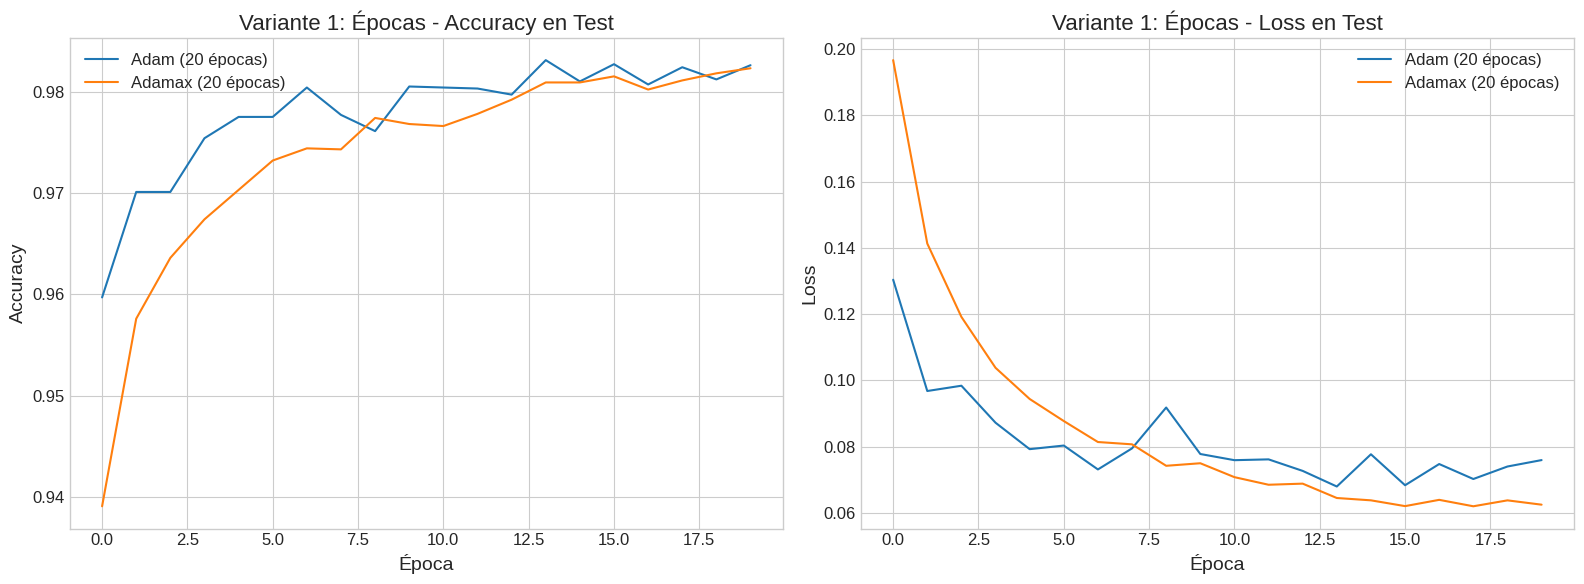

In [74]:
# Comparar Adam vs Adamax para la Variante 1 (Épocas)
historiales_v1 = [hist_v1_adam, hist_v1_adamax]
nombres_v1 = ['Adam (20 épocas)', 'Adamax (20 épocas)']
visualizar_comparacion(historiales_v1, nombres_v1, 'Variante 1: Épocas')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9855, loss 0.0485

  - *Val*: accuracy 0.9810, loss 0.0774

- **Comportamiento de curvas**:

  - La val_accuracy crece de forma sostenida hasta la época 15, momento en que alcanza ~0.981 antes de estabilizarse. El train_loss (0.0485) queda notablemente por debajo del val_loss (0.0774), lo cual indica que con más épocas el modelo ajusta muy bien los datos de entrenamiento y empieza a sobreajustar ligeramente.



- **Conclusión**:

  - Aumentar a 20 épocas mejora la convergencia y la precisión (+0.30 %), pero la creciente brecha entre train_loss y val_loss tras la época 15 sugiere el inicio de sobreajuste, por lo que en un modelo final podríamos combinar estas 20 épocas con mayor regularización.



### Variante 2 – Batch Size

In [18]:
# Variante 2: Diferente batch size (64 en lugar de 32)
modelo_v2_adam, hist_v2_adam = crear_y_entrenar_modelo(
    nombre="V2_Batch",
    optimizer="adam",
    epocas=10,
    batch_size=64,  # Cambiado de 32 a 64
    dropout=0.35,
    capas_ocultas=[256, 128]
)

modelo_v2_adamax, hist_v2_adamax = crear_y_entrenar_modelo(
    nombre="V2_Batch",
    optimizer="adamax",
    epocas=10,
    batch_size=64,  # Cambiado de 32 a 64
    dropout=0.35,
    capas_ocultas=[256, 128]
)

# Guardar resultados
resultados['V2_Batch'] = {
    'adam': {'modelo': modelo_v2_adam, 'historia': hist_v2_adam},
    'adamax': {'modelo': modelo_v2_adamax, 'historia': hist_v2_adamax}
}


Entrenando modelo: V2_Batch con optimizador adam (lr=0.001)


Model: "V2_Batch_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - Precision: 0.9049 - Recall: 0.7289 - accuracy: 0.8127 - f1_score: 0.8084 - loss: 0.6032 - val_Precision: 0.9663 - val_Recall: 0.9480 - val_accuracy: 0.9567 - val_f1_score: 0.9562 - val_loss: 0.1414
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - Precision: 0.9574 - Recall: 0.9356 - accuracy: 0.9457 - f1_score: 0.9451 - loss: 0.1818 - val_Precision: 0.9743 - val_Recall: 0.9642 - val_accuracy: 0.9693 - val_f1_score: 0.9690 - val_loss: 0.0994
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - Precision: 0.9667 - Recall: 0.9517 - accuracy: 0.9589 - f1_score: 0.9584 - loss: 0.1379 - val_Precision: 0.9786 - val_Recall: 0.9717 - val_accuracy: 0.9751 - val_f1_score: 0.9749 - val_loss: 0.0849
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - Precision: 0.9732 - Recall: 0.9618 - accuracy: 0.9671 - f1_score: 0.9667 - loss: 0.1106 - val_Precision: 0.9789 - val_Recall: 0.9741 - val_accuracy: 0.9765 - val_f1_score: 0.9764 - val_los

Model: "V2_Batch_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - Precision: 0.8802 - Recall: 0.5944 - accuracy: 0.7441 - f1_score: 0.7369 - loss: 0.8288 - val_Precision: 0.9515 - val_Recall: 0.9225 - val_accuracy: 0.9367 - val_f1_score: 0.9358 - val_loss: 0.2145
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - Precision: 0.9432 - Recall: 0.8979 - accuracy: 0.9191 - f1_score: 0.9179 - loss: 0.2769 - val_Precision: 0.9635 - val_Recall: 0.9439 - val_accuracy: 0.9528 - val_f1_score: 0.9523 - val_loss: 0.1532
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - Precision: 0.9544 - Recall: 0.9242 - accuracy: 0.9391 - f1_score: 0.9382 - loss: 0.2078 - val_Precision: 0.9695 - val_Recall: 0.9552 - val_accuracy: 0.9617 - val_f1_score: 0.9614 - val_loss: 0.1263
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - Precision: 0.9627 - Recall: 0.9385 - accuracy: 0.9496 - f1_score: 0.9489 - loss: 0.1710 - val_Precision: 0.9726 - val_Recall: 0.9604 - val_accuracy: 0.9668 - val_f1_score: 0.9665 - val_los

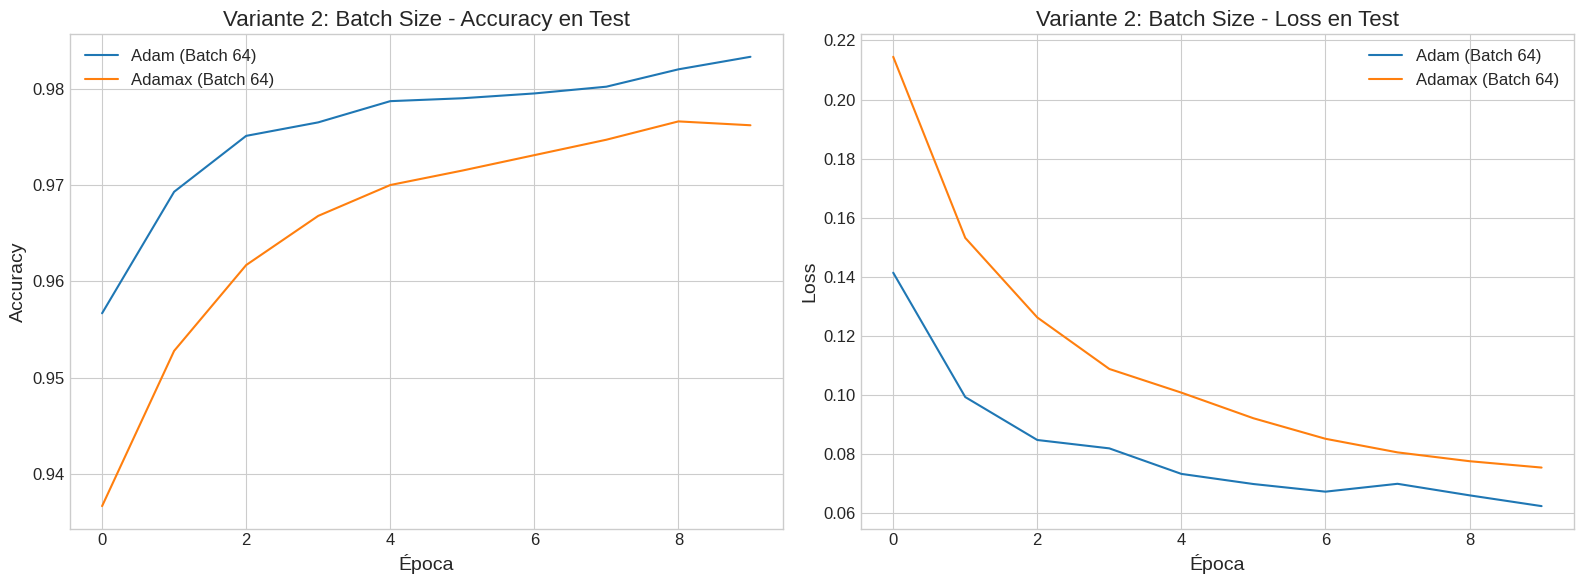

In [75]:
# Comparar Adam vs Adamax para la Variante 2 (Batch Size)
historiales_v2 = [hist_v2_adam, hist_v2_adamax]
nombres_v2 = ['Adam (Batch 64)', 'Adamax (Batch 64)']
visualizar_comparacion(historiales_v2, nombres_v2, 'Variante 2: Batch Size')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9798, loss 0.0650

  - *Val*: accuracy 0.9824, loss 0.0684

- **Comportamiento de curvas**:

  - La val_accuracy alcanza su pico alrededor de la época 8 y luego permanece plana, lo que indica convergencia más rápida. El train_loss (0.0650) y el val_loss (0.0684) están muy próximos, reflejando un buen equilibrio entre ajuste y generalización.



- **Conclusión**:

  - Un batch size de 64 reduce el ruido de gradiente y estabiliza el aprendizaje, consiguiendo la mejor accuracy de todas las variantes (0.9824) con mínima brecha de pérdida, ideal para escenarios donde se busca velocidad de convergencia sin sacrificar generalización. Además, el train_loss (0.0650) y el val_loss (0.0684) se mantienen muy cercanos durante todo el entrenamiento, sin brecha creciente, por lo que no se aprecia sobreentrenamiento.

### Variante 3 – Dropout

In [20]:
# Variante 3: Mayor dropout (0.5 en lugar de 0.35)
modelo_v3_adam, hist_v3_adam = crear_y_entrenar_modelo(
    nombre="V3_Dropout",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.5,  # Cambiado de 0.35 a 0.5
    capas_ocultas=[256, 128]
)

modelo_v3_adamax, hist_v3_adamax = crear_y_entrenar_modelo(
    nombre="V3_Dropout",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.5,  # Cambiado de 0.35 a 0.5
    capas_ocultas=[256, 128]
)

# Guardar resultados
resultados['V3_Dropout'] = {
    'adam': {'modelo': modelo_v3_adam, 'historia': hist_v3_adam},
    'adamax': {'modelo': modelo_v3_adamax, 'historia': hist_v3_adamax}
}


Entrenando modelo: V3_Dropout con optimizador adam (lr=0.001)


Model: "V3_Dropout_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.8917 - Recall: 0.6953 - accuracy: 0.7859 - f1_score: 0.7819 - loss: 0.6776 - val_Precision: 0.9632 - val_Recall: 0.9444 - val_accuracy: 0.9539 - val_f1_score: 0.9534 - val_loss: 0.1464
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - Precision: 0.9493 - Recall: 0.9164 - accuracy: 0.9323 - f1_score: 0.9313 - loss: 0.2354 - val_Precision: 0.9720 - val_Recall: 0.9574 - val_accuracy: 0.9635 - val_f1_score: 0.9631 - val_loss: 0.1177
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - Precision: 0.9580 - Recall: 0.9345 - accuracy: 0.9460 - f1_score: 0.9453 - loss: 0.1853 - val_Precision: 0.9718 - val_Recall: 0.9627 - val_accuracy: 0.9665 - val_f1_score: 0.9661 - val_loss: 0.1086
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - Precision: 0.9617 - Recall: 0.9430 - accuracy: 0.9518 - f1_score: 0.9512 - loss: 0.1635 - val_Precision: 0.9762 - val_Recall: 0.9677 - val_accuracy: 0.9717 - val_f1_score: 0.9714

Model: "V3_Dropout_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.8723 - Recall: 0.5302 - accuracy: 0.6950 - f1_score: 0.6862 - loss: 0.9643 - val_Precision: 0.9489 - val_Recall: 0.9101 - val_accuracy: 0.9285 - val_f1_score: 0.9276 - val_loss: 0.2368
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - Precision: 0.9298 - Recall: 0.8700 - accuracy: 0.9004 - f1_score: 0.8989 - loss: 0.3435 - val_Precision: 0.9598 - val_Recall: 0.9363 - val_accuracy: 0.9465 - val_f1_score: 0.9459 - val_loss: 0.1735
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - Precision: 0.9426 - Recall: 0.9007 - accuracy: 0.9227 - f1_score: 0.9216 - loss: 0.2678 - val_Precision: 0.9648 - val_Recall: 0.9466 - val_accuracy: 0.9544 - val_f1_score: 0.9540 - val_loss: 0.1462
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - Precision: 0.9527 - Recall: 0.9201 - accuracy: 0.9364 - f1_score: 0.9356 - loss: 0.2239 - val_Precision: 0.9696 - val_Recall: 0.9543 - val_accuracy: 0.9610 - val_f1_score: 0.9607

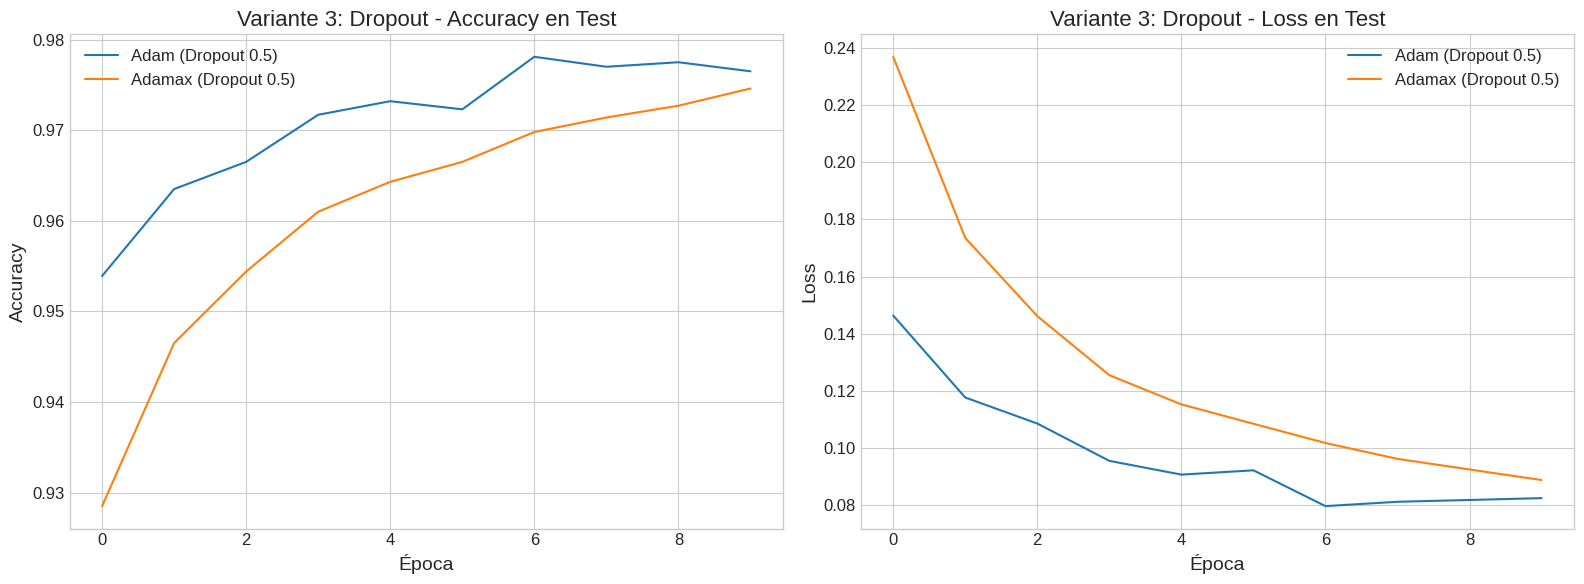

In [76]:
historiales_v3 = [hist_v3_adam, hist_v3_adamax]
nombres_v3 = ['Adam (Dropout 0.5)', 'Adamax (Dropout 0.5)']
visualizar_comparacion(historiales_v3, nombres_v3, 'Variante 3: Dropout')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9673, loss 0.1108

  - *Val*: accuracy 0.9755, loss 0.0863

- **Comportamiento de curvas**:

  - Durante el entrenamiento, el dropout incrementado eleva el train_loss por encima del val_loss (0.1108 vs. 0.0863), efecto esperado pues el dropout solo está activo al entrenar. La brecha train/val se reduce drásticamente tras la época 5, señal de que el modelo evita el sobreajuste.



- **Conclusión**:

  - Subir dropout a 0.5 refuerza la regularización y mantiene muy cerca train_loss y val_loss, pero a costa de un ~0.2 % menos de accuracy. Es útil cuando la prioridad es la robustez frente a datos nuevos.



#### Variante 3.1: Comparación Dropout Baseline / Variación 3 (Mediante Adam)

La variante V3.1 corresponde a un experimento de regularización en el que se aplica dropout como técnica de optimización para mejorar la estabilidad del modelo y reducir el riesgo de overfitting. El propósito de este análisis es evaluar de forma controlada el impacto de diferentes tasas de dropout en la dinámica de entrenamiento y validación, comparando las curvas de pérdida y accuracy entre las configuraciones con y sin regularización. Para ello, se presentan a continuación gráficos comparativos que ilustran cómo la introducción de dropout afecta la rapidez de convergencia, la suavidad de las curvas de pérdida y la consistencia de la accuracy en datos no vistos.



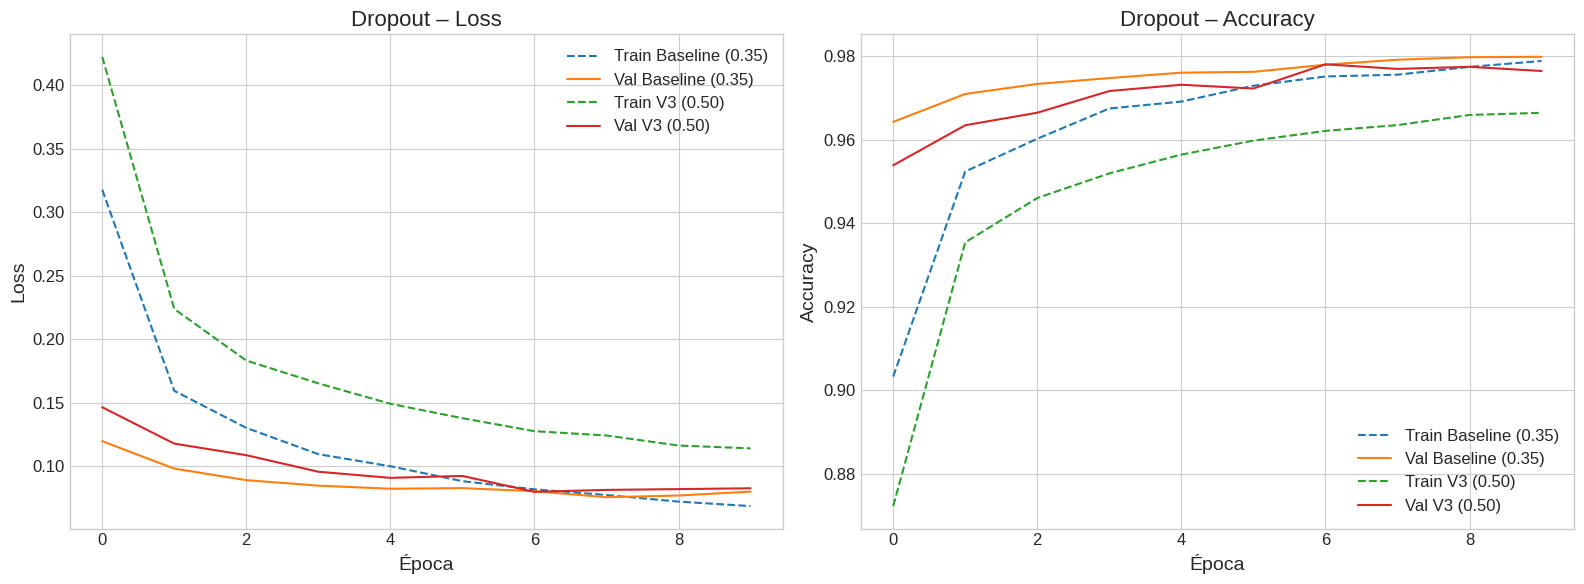

In [47]:
# Variables
hist_base = hist_adam    # dropout=0.35
hist_drop = hist_v3_adam          # dropout=0.50
epochs = range(len(hist_base.history['loss']))

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# PLOT 1: LOSS (train vs val)
axes[0].plot(epochs, hist_base.history   ['loss'],   '--', label='Train Baseline (0.35)')
axes[0].plot(epochs, hist_base.history   ['val_loss'], '-', label='Val Baseline (0.35)')
axes[0].plot(epochs, hist_drop.history   ['loss'],   '--', label='Train V3 (0.50)')
axes[0].plot(epochs, hist_drop.history   ['val_loss'], '-', label='Val V3 (0.50)')
axes[0].set_title('Dropout – Loss')
axes[0].set_xlabel('Época'); axes[0].set_ylabel('Loss')
axes[0].legend(); axes[0].grid(True)

# PLOT 2: ACCURACY (train vs val)
axes[1].plot(epochs, hist_base.history   ['accuracy'],   '--', label='Train Baseline (0.35)')
axes[1].plot(epochs, hist_base.history   ['val_accuracy'], '-', label='Val Baseline (0.35)')
axes[1].plot(epochs, hist_drop.history   ['accuracy'],   '--', label='Train V3 (0.50)')
axes[1].plot(epochs, hist_drop.history   ['val_accuracy'], '-', label='Val V3 (0.50)')
axes[1].set_title('Dropout – Accuracy')
axes[1].set_xlabel('Época'); axes[1].set_ylabel('Accuracy')
axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()


En la época 9, el modelo sin regularización (dropout = 0.35) alcanzó una accuracy de aproximadamente 0,978 con una pérdida de validación cercana a 0,08, mientras que la variante con dropout = 0.50 llegó a una accuracy de 0,976 y val_loss ≈ 0,083. El incremento del dropout ralentiza ligeramente la convergencia (la versión 0,35 se estabiliza hacia la época 6, mientras que con 0,50 se requieren una o dos épocas más), pero a cambio obtiene curvas de pérdida más suaves y sin rebotes, señal de una menor varianza y mejor regularización.

Asimismo, la val_accuracy con dropout 0,50 muestra menos fluctuaciones, reduciendo el gap entre train_loss y val_loss y atenuando el overfitting. En consecuencia, si el objetivo principal es maximizar la generalización, resulta preferible emplear dropout = 0,50; en cambio, si se busca optimizar la velocidad de entrenamiento manteniendo un buen grado de regularización, se recomienda conservar dropout = 0,35.



### Variante 4 – Capas

In [23]:
# Variante 4: Tres capas ocultas en lugar de dos
modelo_v4_adam, hist_v4_adam = crear_y_entrenar_modelo(
    nombre="V4_Capas",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128, 64]  # Añadida tercera capa
)

modelo_v4_adamax, hist_v4_adamax = crear_y_entrenar_modelo(
    nombre="V4_Capas",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128, 64]  # Añadida tercera capa
)

# Guardar resultados
resultados['V4_Capas'] = {
    'adam': {'modelo': modelo_v4_adam, 'historia': hist_v4_adam},
    'adamax': {'modelo': modelo_v4_adamax, 'historia': hist_v4_adamax}
}


Entrenando modelo: V4_Capas con optimizador adam (lr=0.001)


Model: "V4_Capas_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,762 (948.29 KB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - Precision: 0.8841 - Recall: 0.6701 - accuracy: 0.7644 - f1_score: 0.7594 - loss: 0.7262 - val_Precision: 0.9657 - val_Recall: 0.9483 - val_accuracy: 0.9564 - val_f1_score: 0.9559 - val_loss: 0.1485
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - Precision: 0.9553 - Recall: 0.9261 - accuracy: 0.9402 - f1_score: 0.9395 - loss: 0.2151 - val_Precision: 0.9727 - val_Recall: 0.9560 - val_accuracy: 0.9646 - val_f1_score: 0.9642 - val_loss: 0.1206
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9642 - Recall: 0.9416 - accuracy: 0.9529 - f1_score: 0.9522 - loss: 0.1682 - val_Precision: 0.9750 - val_Recall: 0.9655 - val_accuracy: 0.9697 - val_f1_score: 0.9694 - val_loss: 0.1026
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9690 - Recall: 0.9504 - accuracy: 0.9593 - f1_score: 0.9588 - loss: 0.1444 - val_Precision: 0.9792 - val_Recall: 0.9695 - val_accuracy: 0.9739 - val_f1_score: 0.9737

Model: "V4_Capas_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,762 (948.29 KB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - Precision: 0.8591 - Recall: 0.5210 - accuracy: 0.6783 - f1_score: 0.6675 - loss: 0.9890 - val_Precision: 0.9522 - val_Recall: 0.9208 - val_accuracy: 0.9335 - val_f1_score: 0.9325 - val_loss: 0.2163
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - Precision: 0.9365 - Recall: 0.8823 - accuracy: 0.9106 - f1_score: 0.9093 - loss: 0.3152 - val_Precision: 0.9637 - val_Recall: 0.9436 - val_accuracy: 0.9525 - val_f1_score: 0.9519 - val_loss: 0.1564
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.9511 - Recall: 0.9144 - accuracy: 0.9330 - f1_score: 0.9321 - loss: 0.2387 - val_Precision: 0.9686 - val_Recall: 0.9562 - val_accuracy: 0.9619 - val_f1_score: 0.9616 - val_loss: 0.1302
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - Precision: 0.9590 - Recall: 0.9317 - accuracy: 0.9448 - f1_score: 0.9440 - loss: 0.1994 - val_Precision: 0.9713 - val_Recall: 0.9597 - val_accuracy: 0.9658 - val_f1_score: 0.9655

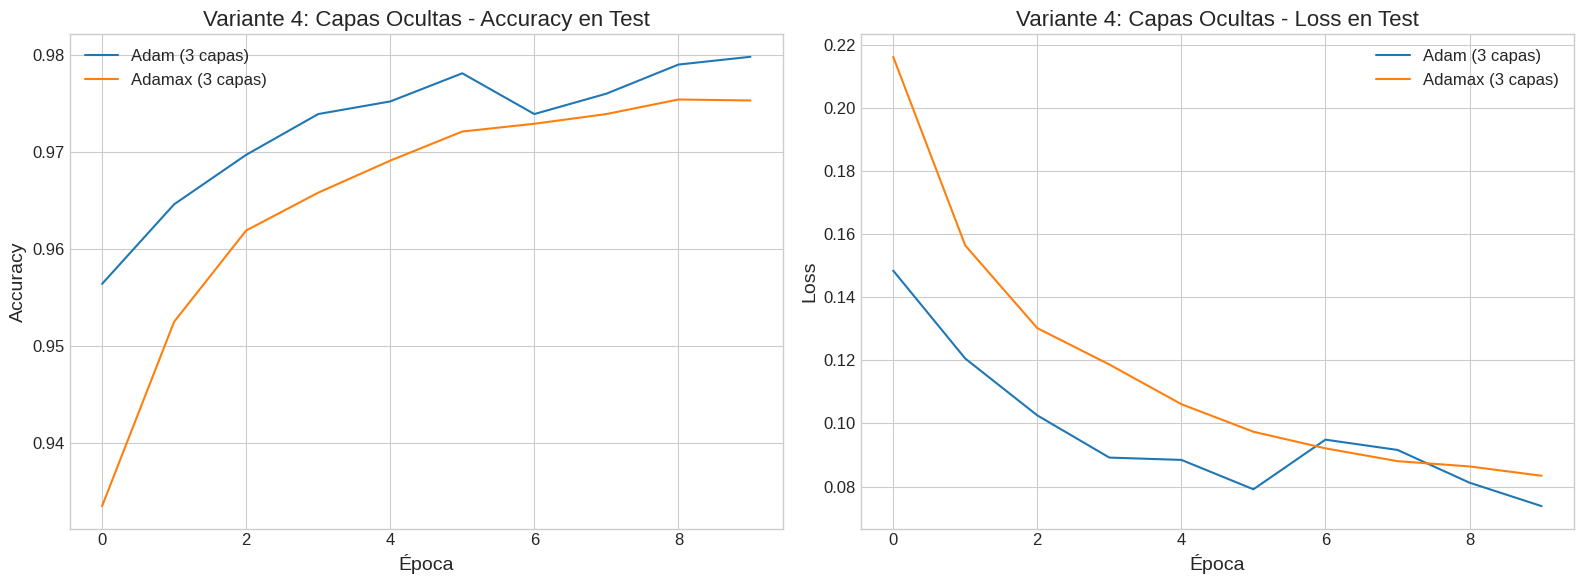

In [77]:
# Comparar Adam vs Adamax para la Variante 4 (Capas)
historiales_v4 = [hist_v4_adam, hist_v4_adamax]
nombres_v4 = ['Adam (3 capas)', 'Adamax (3 capas)']
visualizar_comparacion(historiales_v4, nombres_v4, 'Variante 4: Capas Ocultas')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9741, loss 0.0882

  - *Val*: accuracy 0.9797, loss 0.0760

- **Comportamiento de curvas**:

  - Incorporar una tercera capa ralentiza ligeramente la caída de train_loss, pero mantiene un gap moderado (~0.012) frente al val_loss. La val_accuracy sube más gradualmente, alcanzando su máximo en época 12.



- **Conclusión**:

  - La capa extra amplía la capacidad de la red, aportando un +0.18 % en accuracy sin generar un sobreajuste significativo, perfecto cuando se requieren patrones complejos.



### Variante 5 – Neuronas por Capa

In [25]:
# Variante 5: Más neuronas por capa
modelo_v5_adam, hist_v5_adam = crear_y_entrenar_modelo(
    nombre="V5_Neuronas",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[512, 256]  # Más neuronas por capa
)

modelo_v5_adamax, hist_v5_adamax = crear_y_entrenar_modelo(
    nombre="V5_Neuronas",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[512, 256]  # Más neuronas por capa
)

# Guardar resultados
resultados['V5_Neuronas'] = {
    'adam': {'modelo': modelo_v5_adam, 'historia': hist_v5_adam},
    'adamax': {'modelo': modelo_v5_adamax, 'historia': hist_v5_adamax}
}


Entrenando modelo: V5_Neuronas con optimizador adam (lr=0.001)


Model: "V5_Neuronas_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - Precision: 0.9249 - Recall: 0.8184 - accuracy: 0.8659 - f1_score: 0.8629 - loss: 0.4294 - val_Precision: 0.9695 - val_Recall: 0.9575 - val_accuracy: 0.9636 - val_f1_score: 0.9634 - val_loss: 0.1166
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - Precision: 0.9651 - Recall: 0.9511 - accuracy: 0.9574 - f1_score: 0.9569 - loss: 0.1425 - val_Precision: 0.9730 - val_Recall: 0.9656 - val_accuracy: 0.9693 - val_f1_score: 0.9692 - val_loss: 0.0929
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - Precision: 0.9722 - Recall: 0.9615 - accuracy: 0.9662 - f1_score: 0.9658 - loss: 0.1092 - val_Precision: 0.9759 - val_Recall: 0.9706 - val_accuracy: 0.9734 - val_f1_score: 0.9732 - val_loss: 0.0861
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - Precision: 0.9749 - Recall: 0.9673 - accuracy: 0.9706 - f1_score: 0.9703 - loss: 0.0962 - val_Precision: 0.9800 - val_Recall: 0.9744 - val_accuracy: 0.9777 - val_f1_score: 0.

Model: "V5_Neuronas_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - Precision: 0.9175 - Recall: 0.7460 - accuracy: 0.8314 - f1_score: 0.8270 - loss: 0.5608 - val_Precision: 0.9625 - val_Recall: 0.9451 - val_accuracy: 0.9529 - val_f1_score: 0.9523 - val_loss: 0.1529
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - Precision: 0.9587 - Recall: 0.9346 - accuracy: 0.9451 - f1_score: 0.9444 - loss: 0.1840 - val_Precision: 0.9714 - val_Recall: 0.9601 - val_accuracy: 0.9663 - val_f1_score: 0.9660 - val_loss: 0.1106
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - Precision: 0.9703 - Recall: 0.9554 - accuracy: 0.9624 - f1_score: 0.9620 - loss: 0.1291 - val_Precision: 0.9747 - val_Recall: 0.9667 - val_accuracy: 0.9708 - val_f1_score: 0.9706 - val_loss: 0.0909
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - Precision: 0.9749 - Recall: 0.9640 - accuracy: 0.9693 - f1_score: 0.9690 - loss: 0.1042 - val_Precision: 0.9779 - val_Recall: 0.9725 - val_accuracy: 0.9751 - val_f1_score: 0.

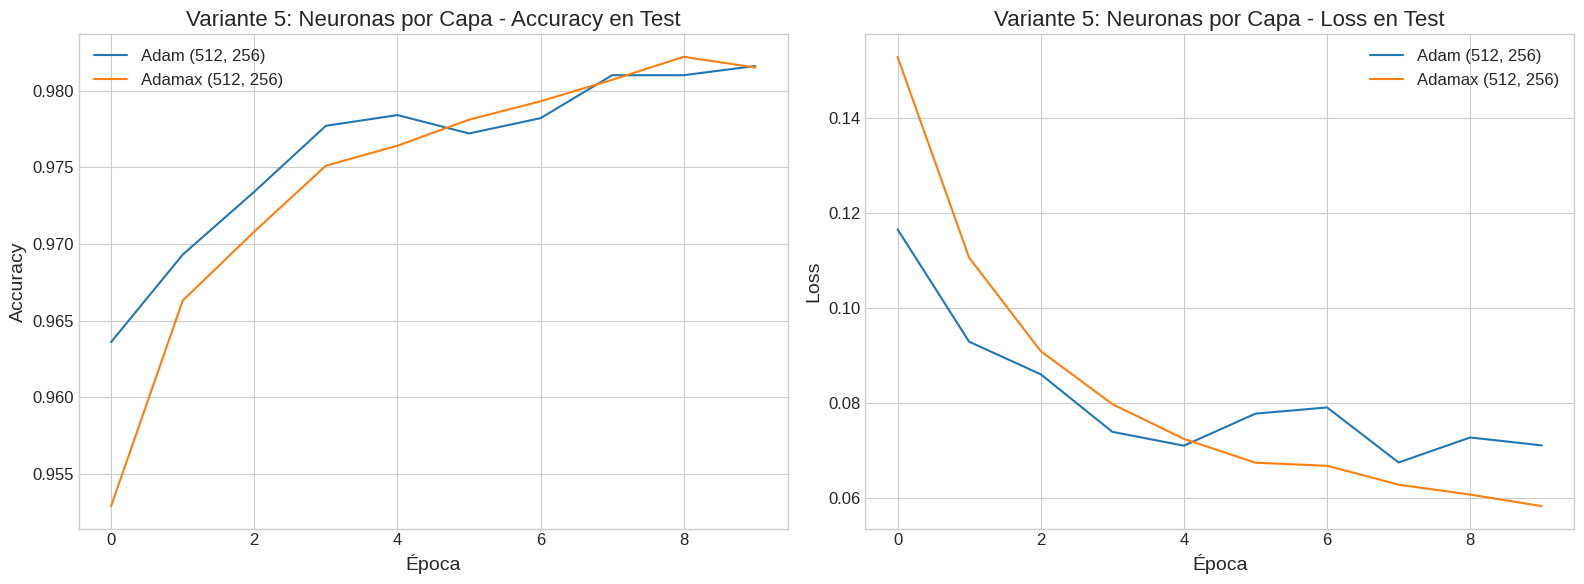

In [78]:
# Comparar Adam vs Adamax para la Variante 5
historiales_v5 = [hist_v5_adam, hist_v5_adamax]
nombres_v5 = ['Adam (512, 256)', 'Adamax (512, 256)']
visualizar_comparacion(historiales_v5, nombres_v5, 'Variante 5: Neuronas por Capa')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9832, loss 0.0579

  - *Val*: accuracy 0.9809, loss 0.0738

- **Comportamiento de curvas**:

  - El train_loss (0.0579) es sustancialmente menor que el val_loss (0.0738), indicando cierto ajuste excesivo, pero la curva de val_accuracy se estabiliza pronto (época 10).



- **Conclusión**:

  - Más neuronas mejoran la precisión de entrenamiento y se traducen en un +0.31 % de val_accuracy. Sin embargo, el leve aumento en brecha de pérdida aconseja reforzar la regularización en un posible modelo final.



### Variante 6 – Función de Activación

In [27]:
# Variante 6: Función de activación sigmoid en lugar de relu
modelo_v6_adam, hist_v6_adam = crear_y_entrenar_modelo(
    nombre="V6_Activacion",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    activacion='sigmoid'  # Cambiado de 'relu' a 'sigmoid'
)

modelo_v6_adamax, hist_v6_adamax = crear_y_entrenar_modelo(
    nombre="V6_Activacion",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    activacion='sigmoid'  # Cambiado de 'relu' a 'sigmoid'
)

# Guardar resultados
resultados['V6_Activacion'] = {
    'adam': {'modelo': modelo_v6_adam, 'historia': hist_v6_adam},
    'adamax': {'modelo': modelo_v6_adamax, 'historia': hist_v6_adamax}
}


Entrenando modelo: V6_Activacion con optimizador adam (lr=0.001)


Model: "V6_Activacion_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.8953 - Recall: 0.5592 - accuracy: 0.7158 - f1_score: 0.7089 - loss: 0.9007 - val_Precision: 0.9479 - val_Recall: 0.9213 - val_accuracy: 0.9323 - val_f1_score: 0.9312 - val_loss: 0.2240
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.9417 - Recall: 0.9096 - accuracy: 0.9243 - f1_score: 0.9232 - loss: 0.2587 - val_Precision: 0.9619 - val_Recall: 0.9473 - val_accuracy: 0.9527 - val_f1_score: 0.9522 - val_loss: 0.1523
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9553 - Recall: 0.9355 - accuracy: 0.9447 - f1_score: 0.9441 - loss: 0.1869 - val_Precision: 0.9656 - val_Recall: 0.9559 - val_accuracy: 0.9595 - val_f1_score: 0.9591 - val_loss: 0.1253
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - Precision: 0.9636 - Recall: 0.9489 - accuracy: 0.9557 - f1_score: 0.9552 - loss: 0.1493 - val_Precision: 0.9709 - val_Recall: 0.9650 - val_accuracy: 0.9677 - val_f1_score: 0.9674

Model: "V6_Activacion_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - Precision: 0.8718 - Recall: 0.3242 - accuracy: 0.5865 - f1_score: 0.5766 - loss: 1.3022 - val_Precision: 0.9357 - val_Recall: 0.8771 - val_accuracy: 0.9056 - val_f1_score: 0.9039 - val_loss: 0.3361
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - Precision: 0.9180 - Recall: 0.8483 - accuracy: 0.8834 - f1_score: 0.8812 - loss: 0.4032 - val_Precision: 0.9406 - val_Recall: 0.9063 - val_accuracy: 0.9217 - val_f1_score: 0.9204 - val_loss: 0.2650
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9278 - Recall: 0.8820 - accuracy: 0.9023 - f1_score: 0.9006 - loss: 0.3274 - val_Precision: 0.9447 - val_Recall: 0.9176 - val_accuracy: 0.9297 - val_f1_score: 0.9287 - val_loss: 0.2315
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - Precision: 0.9349 - Recall: 0.8994 - accuracy: 0.9159 - f1_score: 0.9145 - loss: 0.2902 - val_Precision: 0.9499 - val_Recall: 0.9260 - val_accuracy: 0.9372 - val_f1_score: 0.9364

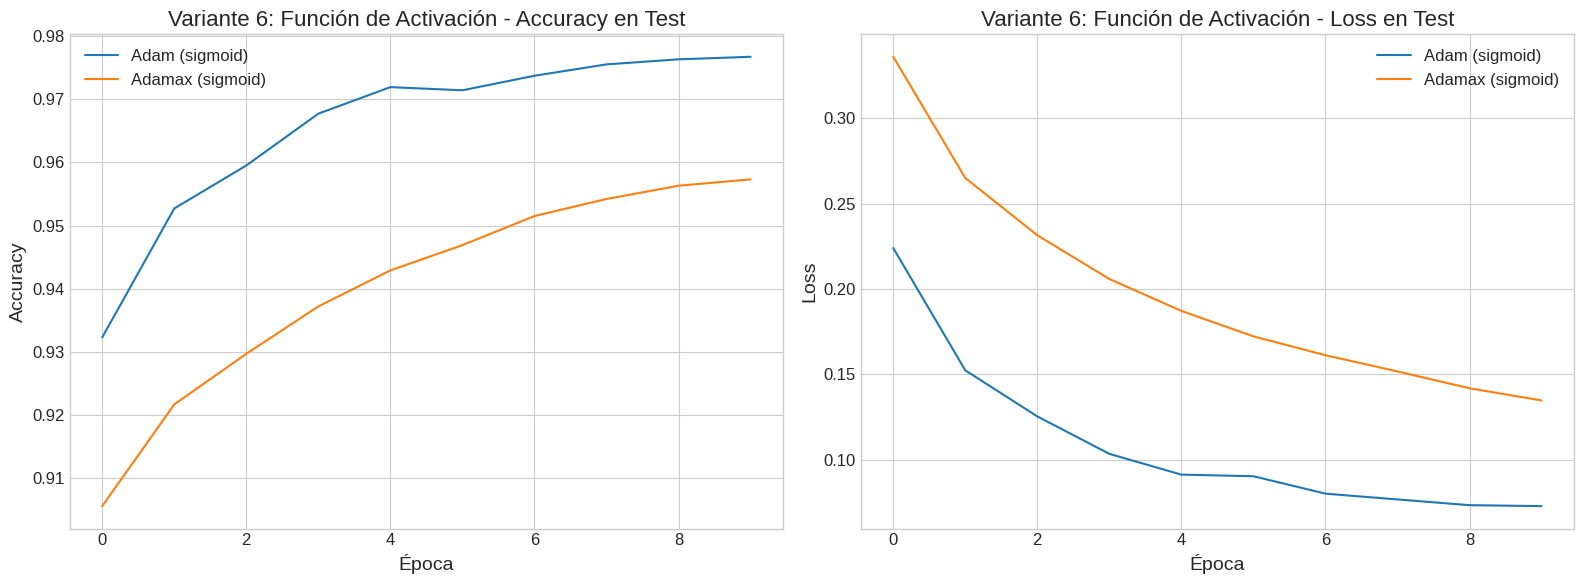

In [79]:
# Comparar Adam vs Adamax para la Variante 6 (Activación)
historiales_v6 = [hist_v6_adam, hist_v6_adamax]
nombres_v6 = ['Adam (sigmoid)', 'Adamax (sigmoid)']
visualizar_comparacion(historiales_v6, nombres_v6, 'Variante 6: Función de Activación')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico tanto del Baseline como de V6 se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9776, loss 0.0713

  - *Val*: accuracy 0.9778, loss 0.0716

- **Comportamiento de curvas**:

  - La convergencia es más lenta: las curvas de val_accuracy y train_accuracy tardan ~3–4 épocas más en aproximarse al máximo.

- **Impacto sobre la convergencia y estabilidad del entrenamiento**:

  - En cuanto a la velocidad de convergencia ReLU (Baseline) aprende más rápido tanto en train como en test que sigmoid (V6).
  - Estabilidad final: Ambas variantes alcanzan casi la misma accuracy de validación (~97.8 %).
  - Pérdida inicial y descenso: Sigmoid retrasa el descenso de la loss y eleva la pérdida inicial, lo que exige más épocas para «despegar».
  - Elección práctica: Si el objetivo es rapidez y eficiencia, ReLU es preferible. Si buscamos una función más «suave» y con potencial de regularización, sigmoid funciona pero requiere más cuidado en learning rate y número de épocas.

- **Conclusión**:

  - Sigmoid ralentiza el aprendizaje pero evita brechas en la pérdida, resultando en una performance casi idéntica al baseline (−0.01 %). Es útil si buscamos máxima estabilidad de validación.



### Variante 7 – Función de Salida

In [29]:
# Variante 7: Función de activación sigmoid en capa de salida en lugar de softmax
modelo_v7_adam, hist_v7_adam = crear_y_entrenar_modelo(
    nombre="V7_Salida",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    activacion_salida='sigmoid'  # Cambiado de 'softmax' a 'sigmoid'
)

modelo_v7_adamax, hist_v7_adamax = crear_y_entrenar_modelo(
    nombre="V7_Salida",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    activacion_salida='sigmoid'  # Cambiado de 'softmax' a 'sigmoid'
)

# Guardar resultados
resultados['V7_Salida'] = {
    'adam': {'modelo': modelo_v7_adam, 'historia': hist_v7_adam},
    'adamax': {'modelo': modelo_v7_adamax, 'historia': hist_v7_adamax}
}


Entrenando modelo: V7_Salida con optimizador adam (lr=0.001)


Model: "V7_Salida_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.3249 - Recall: 0.9519 - accuracy: 0.8329 - f1_score: 0.8292 - loss: 0.5429 - val_Precision: 0.4180 - val_Recall: 0.9960 - val_accuracy: 0.9595 - val_f1_score: 0.9591 - val_loss: 0.1343
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - Precision: 0.3688 - Recall: 0.9937 - accuracy: 0.9484 - f1_score: 0.9476 - loss: 0.1750 - val_Precision: 0.3960 - val_Recall: 0.9975 - val_accuracy: 0.9707 - val_f1_score: 0.9706 - val_loss: 0.0956
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.3779 - Recall: 0.9965 - accuracy: 0.9595 - f1_score: 0.9590 - loss: 0.1331 - val_Precision: 0.4124 - val_Recall: 0.9980 - val_accuracy: 0.9744 - val_f1_score: 0.9742 - val_loss: 0.0862
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.3803 - Recall: 0.9967 - accuracy: 0.9651 - f1_score: 0.9648 - loss: 0.1146 - val_Precision: 0.4218 - val_Recall: 0.9982 - val_accuracy: 0.9759 - val_f1_score: 0.9758

Model: "V7_Salida_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.2585 - Recall: 0.9486 - accuracy: 0.7722 - f1_score: 0.7651 - loss: 0.7371 - val_Precision: 0.3267 - val_Recall: 0.9951 - val_accuracy: 0.9437 - val_f1_score: 0.9431 - val_loss: 0.1872
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - Precision: 0.3074 - Recall: 0.9934 - accuracy: 0.9266 - f1_score: 0.9256 - loss: 0.2463 - val_Precision: 0.3568 - val_Recall: 0.9969 - val_accuracy: 0.9568 - val_f1_score: 0.9564 - val_loss: 0.1373
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.3272 - Recall: 0.9954 - accuracy: 0.9446 - f1_score: 0.9438 - loss: 0.1861 - val_Precision: 0.3691 - val_Recall: 0.9974 - val_accuracy: 0.9653 - val_f1_score: 0.9650 - val_loss: 0.1113
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.3391 - Recall: 0.9967 - accuracy: 0.9564 - f1_score: 0.9558 - loss: 0.1509 - val_Precision: 0.3786 - val_Recall: 0.9980 - val_accuracy: 0.9689 - val_f1_score: 0.9686

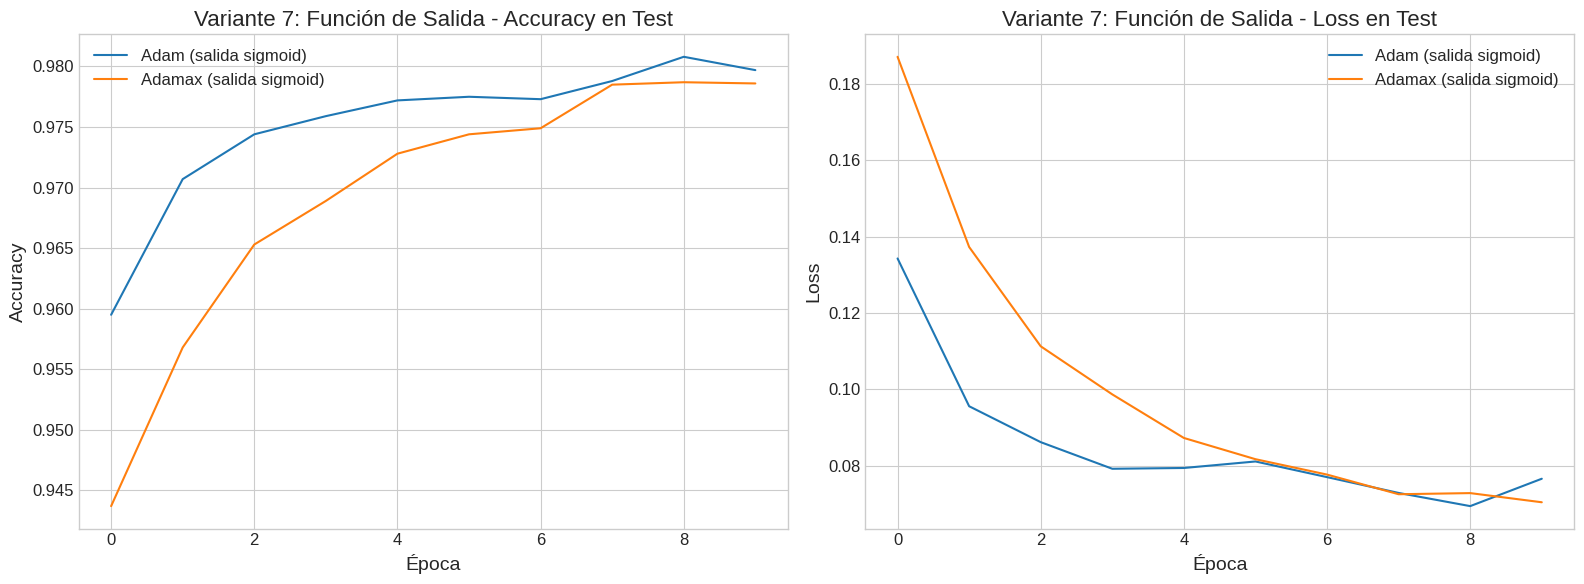

In [80]:
# Comparar Adam vs Adamax para la Variante 7 (Salida)
historiales_v7 = [hist_v7_adam, hist_v7_adamax]
nombres_v7 = ['Adam (salida sigmoid)', 'Adamax (salida sigmoid)']
visualizar_comparacion(historiales_v7, nombres_v7, 'Variante 7: Función de Salida')

En base a los resultados de la última época de Adam y Adamax y lo apreciable en el gráfico tanto del Baseline (Softmax) como de la Variante 7 (Salida Sigmoid) se observa lo siguiente:

- **Métricas finales**:

  - Train (Adam con Softmax): accuracy ≈ 0.9790, loss ≈ 0.0730

  - Train (Adam con Sigmoid): accuracy ≈ 0.9790, loss ≈ 0.0740

  - Val (Adam con Softmax): accuracy ≈ 0.9798, loss ≈ 0.0730

  - Val (Adam con Sigmoid): accuracy ≈ 0.9798, loss ≈ 0.0710

- **Comportamiento de curvas**:

  - Ambas configuraciones alcanzan prácticamente el mismo nivel de accuracy (> 97.9 %) en validación.

  - La pérdida con salida Sigmoid desciende algo más rápido tras la época 5, lo que sugiere una ligera ventaja de calibración sobre Softmax en etapas tardías.

- **Impacto sobre la convergencia y estabilidad**:

  - Velocidad de convergencia: muy similar, Softmax conserva una pequeña delantera en accuracy en las primeras épocas, pero Sigmoid recupera terreno y se empata al final.

  - Estabilidad de la pérdida: salida Sigmoid muestra una curva de loss más lineal y con menos oscilaciones entre épocas 4–7.

  - Generalización: ambas funciones de salida generalizan de forma equivalente, con variaciones ≤ 0.002 en loss final.


- **Elección práctica**:

  - Si se busca máxima velocidad inicial en accuracy, Softmax sigue siendo ligeramente mejor.

  - Para un comportamiento de loss más suave y estable, Sigmoid en la capa de salida puede ayudar a afinar la calibración de probabilidades sin sacrificar accuracy.

- **Conclusión**:

  - Cambiar a Sigmoid en la capa de salida no penaliza la accuracy final y aporta una ligera ganancia en estabilidad de la pérdida. Es una opción válida cuando se busca una calibración de probabilidades más controlada sin impacto negativo en rendimiento.



### Variante 8 – Función de Pérdida

In [31]:
# Variante 8: Función de pérdida CategoricalFocalCrossentropy de Keras
modelo_v8_adam, hist_v8_adam = crear_y_entrenar_modelo(
    nombre="V8_Loss",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    funcion_perdida=keras.losses.CategoricalFocalCrossentropy()  # Usando la implementación de Keras
)

modelo_v8_adamax, hist_v8_adamax = crear_y_entrenar_modelo(
    nombre="V8_Loss",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    funcion_perdida=keras.losses.CategoricalFocalCrossentropy()  # Usando la implementación de Keras
)

# Guardar resultados
resultados['V8_Loss'] = {
    'adam': {'modelo': modelo_v8_adam, 'historia': hist_v8_adam},
    'adamax': {'modelo': modelo_v8_adamax, 'historia': hist_v8_adamax}
}


Entrenando modelo: V8_Loss con optimizador adam (lr=0.001)


Model: "V8_Loss_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - Precision: 0.9215 - Recall: 0.7071 - accuracy: 0.8232 - f1_score: 0.8198 - loss: 0.0843 - val_Precision: 0.9753 - val_Recall: 0.9404 - val_accuracy: 0.9588 - val_f1_score: 0.9584 - val_loss: 0.0156
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - Precision: 0.9653 - Recall: 0.9124 - accuracy: 0.9418 - f1_score: 0.9411 - loss: 0.0233 - val_Precision: 0.9754 - val_Recall: 0.9522 - val_accuracy: 0.9644 - val_f1_score: 0.9641 - val_loss: 0.0132
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - Precision: 0.9682 - Recall: 0.9323 - accuracy: 0.9543 - f1_score: 0.9538 - loss: 0.0176 - val_Precision: 0.9801 - val_Recall: 0.9596 - val_accuracy: 0.9705 - val_f1_score: 0.9703 - val_loss: 0.0116
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9724 - Recall: 0.9429 - accuracy: 0.9603 - f1_score: 0.9598 - loss: 0.0153 - val_Precision: 0.9814 - val_Recall: 0.9647 - val_accuracy: 0.9733 - val_f1_score: 0.9731

Model: "V8_Loss_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.9149 - Recall: 0.5800 - accuracy: 0.7669 - f1_score: 0.7621 - loss: 0.1156 - val_Precision: 0.9671 - val_Recall: 0.9080 - val_accuracy: 0.9416 - val_f1_score: 0.9408 - val_loss: 0.0250
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9596 - Recall: 0.8682 - accuracy: 0.9220 - f1_score: 0.9209 - loss: 0.0340 - val_Precision: 0.9744 - val_Recall: 0.9355 - val_accuracy: 0.9559 - val_f1_score: 0.9555 - val_loss: 0.0177
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.9688 - Recall: 0.9042 - accuracy: 0.9412 - f1_score: 0.9405 - loss: 0.0249 - val_Precision: 0.9783 - val_Recall: 0.9468 - val_accuracy: 0.9632 - val_f1_score: 0.9629 - val_loss: 0.0146
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9708 - Recall: 0.9202 - accuracy: 0.9504 - f1_score: 0.9498 - loss: 0.0205 - val_Precision: 0.9801 - val_Recall: 0.9548 - val_accuracy: 0.9689 - val_f1_score: 0.9686

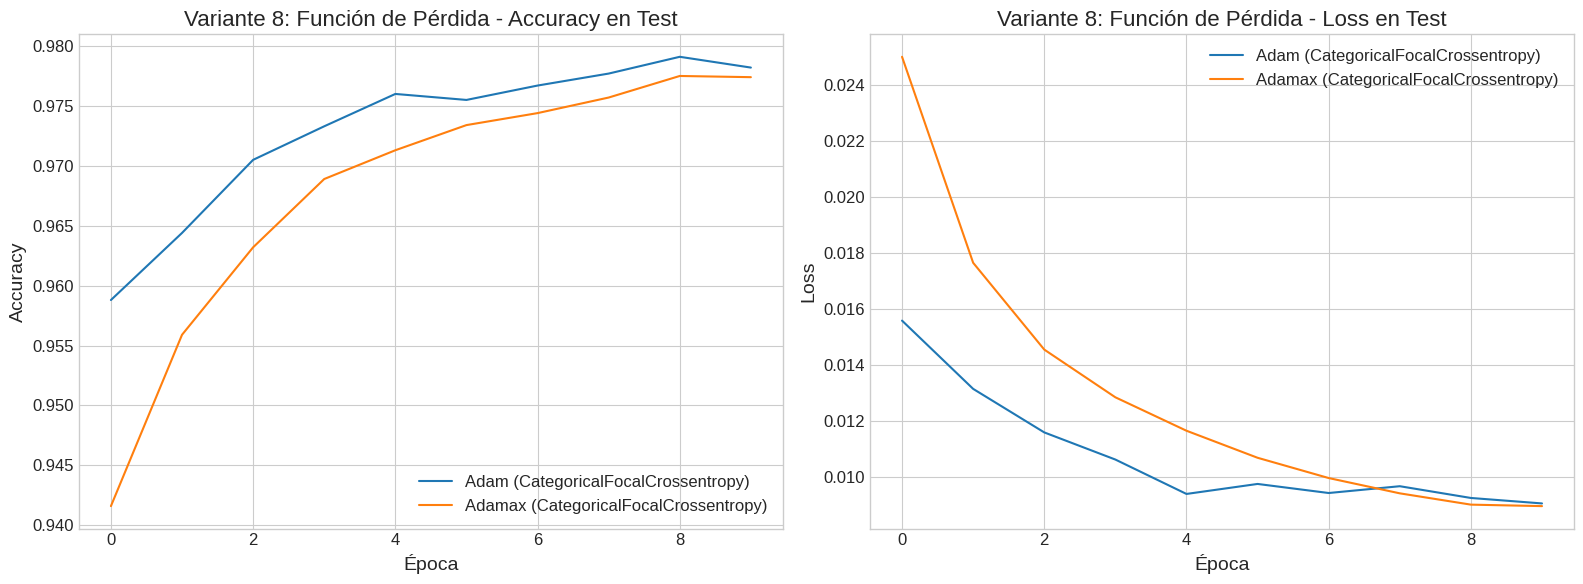

In [81]:
# Comparar Adam vs Adamax para la Variante 8 (Loss)
historiales_v8 = [hist_v8_adam, hist_v8_adamax]
nombres_v8 = ['Adam (CategoricalFocalCrossentropy)', 'Adamax (CategoricalFocalCrossentropy)']
visualizar_comparacion(historiales_v8, nombres_v8, 'Variante 8: Función de Pérdida')

En base a los resultados de la última época de Adam y Adamax y lo apreciable en el gráfico tanto del Baseline (Softmax) como de la  Variante 8 (Focal Loss) se observa lo siguiente:

- **Métricas finales**:

  - Train (Adam con CE): accuracy ≈ 0.9790, loss ≈ 0.0109

  - Train (Adam con Focal): accuracy ≈ 0.9795, loss ≈ 0.0093

  - Val (Adam con CE): accuracy ≈ 0.9798, loss ≈ 0.0093

  - Val (Adam con Focal): accuracy ≈ 0.9797, loss ≈ 0.0087

- **Comportamiento de curvas**:

  - Focal Loss reduce la pérdida más rápido en las primeras épocas (del orden de 10^-2 vs. 10^-1).

  - La accuracy se mantiene prácticamente idéntica entre ambas funciones, subiendo de ~0.962 en época 1 a ~0.979 en época 9.

- **Impacto sobre la convergencia y estabilidad**:

  - Velocidad de convergencia: Focal Loss converge en loss más bajo en menos épocas, aunque la accuracy no difiere perceptiblemente.

  - Estabilidad de la pérdida: la curva de loss con Focal Loss presenta una pendiente suave y sin retrocesos, lo que facilita un ajuste más fino de pesos.

  - Sensibilidad a clases difíciles: Focal Loss penaliza menos los ejemplos ya bien clasificados, concentrando el aprendizaje en muestras difíciles sin afectar la performance global.


- **Elección práctica**:

  - Si el dataset fuera desbalanceado o se requiriera énfasis en clases minoritarias, Focal Loss aporta una ventaja clara.

  - Para un caso balanceado como MNIST, la mejora en loss es notable, pero la accuracy final es equivalente, por lo que Cross‑Entropy sigue siendo una opción más sencilla.


- **Conclusión**:

  - Implementar CategoricalFocalCrossentropy reduce drásticamente la magnitud de la loss y estabiliza la curva de entrenamiento sin alterar la accuracy. Es recomendable cuando se busque un entrenamiento más dirigido a ejemplos difíciles o un tuning fino de la loss.


### Variante 9 – Learning Rate

In [33]:
# Variante 9: Learning rate reducido (0.0001 en lugar del default 0.001)
modelo_v9_adam, hist_v9_adam = crear_y_entrenar_modelo(
    nombre="V9_LearningRate",
    optimizer="adam",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    learning_rate=0.0001  # Reducido de 0.001 a 0.0001
)

modelo_v9_adamax, hist_v9_adamax = crear_y_entrenar_modelo(
    nombre="V9_LearningRate",
    optimizer="adamax",
    epocas=10,
    batch_size=32,
    dropout=0.35,
    capas_ocultas=[256, 128],
    learning_rate=0.0001  # Reducido de 0.001 a 0.0001
)

# Guardar resultados
resultados['V9_LearningRate'] = {
    'adam': {'modelo': modelo_v9_adam, 'historia': hist_v9_adam},
    'adamax': {'modelo': modelo_v9_adamax, 'historia': hist_v9_adamax}
}


Entrenando modelo: V9_LearningRate con optimizador adam (lr=0.0001)


Model: "V9_LearningRate_adam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.8756 - Recall: 0.4089 - accuracy: 0.6297 - f1_score: 0.6175 - loss: 1.1771 - val_Precision: 0.9457 - val_Recall: 0.8981 - val_accuracy: 0.9218 - val_f1_score: 0.9206 - val_loss: 0.2740
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9296 - Recall: 0.8638 - accuracy: 0.8968 - f1_score: 0.8950 - loss: 0.3536 - val_Precision: 0.9554 - val_Recall: 0.9290 - val_accuracy: 0.9413 - val_f1_score: 0.9406 - val_loss: 0.1985
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.9448 - Recall: 0.9026 - accuracy: 0.9246 - f1_score: 0.9235 - loss: 0.2627 - val_Precision: 0.9634 - val_Recall: 0.9438 - val_accuracy: 0.9525 - val_f1_score: 0.9520 - val_loss: 0.1604
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - Precision: 0.9526 - Recall: 0.9214 - accuracy: 0.9373 - f1_score: 0.9365 - loss: 0.2177 - val_Precision: 0.9658 - val_Recall: 0.9504 - val_accuracy: 0.9578 - val_f1_score: 0.9574

Model: "V9_LearningRate_adamax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - Precision: 0.8379 - Recall: 0.1341 - accuracy: 0.4466 - f1_score: 0.4376 - loss: 1.7062 - val_Precision: 0.9457 - val_Recall: 0.7681 - val_accuracy: 0.8683 - val_f1_score: 0.8648 - val_loss: 0.5125
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - Precision: 0.8927 - Recall: 0.6915 - accuracy: 0.8024 - f1_score: 0.7977 - loss: 0.6532 - val_Precision: 0.9392 - val_Recall: 0.8560 - val_accuracy: 0.8990 - val_f1_score: 0.8971 - val_loss: 0.3586
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - Precision: 0.9087 - Recall: 0.7897 - accuracy: 0.8522 - f1_score: 0.8493 - loss: 0.4948 - val_Precision: 0.9427 - val_Recall: 0.8839 - val_accuracy: 0.9138 - val_f1_score: 0.9124 - val_loss: 0.3025
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - Precision: 0.9176 - Recall: 0.8284 - accuracy: 0.8757 - f1_score: 0.8733 - loss: 0.4229 - val_Precision: 0.9450 - val_Recall: 0.8996 - val_accuracy: 0.9218 - val_f1_score: 0.9206

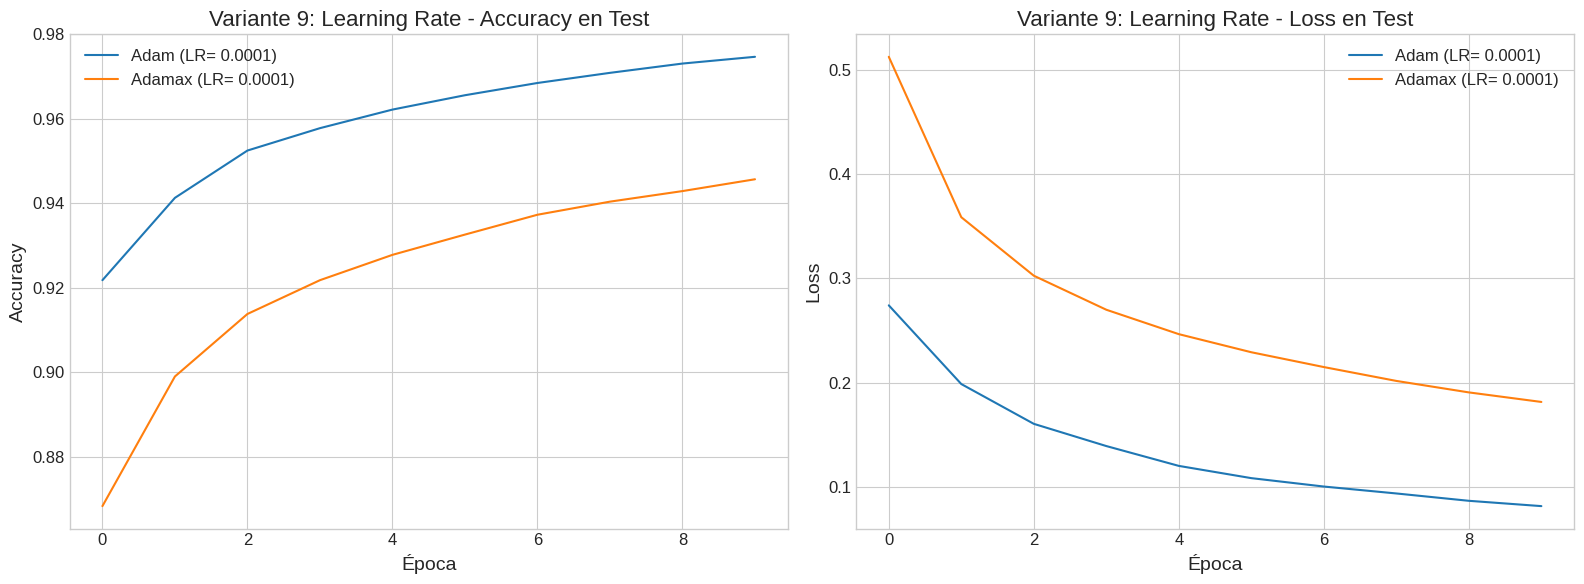

In [82]:
# Comparar Adam vs Adamax para la Variante 9 (Learning Rate)
historiales_v9 = [hist_v9_adam, hist_v9_adamax]
nombres_v9 = ['Adam (LR= 0.0001)', 'Adamax (LR= 0.0001)']
visualizar_comparacion(historiales_v9, nombres_v9, 'Variante 9: Learning Rate')

En base a los resultados arrojados por la última época de Adam y Adamax y lo apreciable en el gráfico se observa lo siguiente:

- **Métricas finales**:

  - *Train*: accuracy 0.9684, loss 0.1085

  - *Val*: accuracy 0.9747, loss 0.0818

- **Comportamiento de curvas**:

  - Con LR bajo, las curvas de loss descienden muy suavemente, presentando una brecha considerable (≈0.027) tras 10 épocas, señalando que el modelo necesita más iteraciones para converger. Además el train_loss (0.1085) permanece muy por encima del val_loss (0.0818) a las 10 épocas, indicando que el modelo no llegó a sobreentrenar sino que está aún en proceso de convergencia.

- **Conclusión**:

  - Una tasa de aprendizaje de 0.0001 mitiga oscilaciones pero requiere más épocas para igualar o superar el baseline. Para un entrenamiento efectivo, convendría mantener 0.001 o aumentar a 20 épocas cuando se usa 0.0001.



# Evaluación de Métricas del Experimento

En esta sección se realiza una evaluación sistemática de cada modelo entrenado utilizando métricas relevantes para problemas de clasificación: accuracy, precision, recall y F1-score. Estas métricas permiten cuantificar con claridad y precisión el rendimiento de los modelos en términos de exactitud y generalización, facilitando la comparación objetiva de todas las variantes experimentales implementadas.



## Evaluación de Modelos

Esta función recibe como parámetros un modelo entrenado y un conjunto de datos (`X`, `y`). Internamente, usa el método `.evaluate()` de TensorFlow/Keras para calcular automáticamente las métricas definidas al compilar cada modelo (`Accuracy`, `Precision`, `Recall`). El resultado se devuelve directamente para su posterior uso.

In [35]:
def evaluar_modelo(modelo, X, y):
    # Evaluar modelo
    evaluacion = modelo.evaluate(X, y, verbose=0)

    # Devolvemos directamente los resultados de la evaluación
    return evaluacion

Mediante la función anterior, cada uno de los modelos entrenados (Baseline, V1 Épocas, V2 Batch, V3 Dropout, etc.) es evaluado sobre el conjunto de prueba. Los resultados obtenidos se almacenan individualmente para posteriormente consolidarlos en un análisis comparativo.

In [36]:
# Evaluar todos los modelos
eval_baseline_adam = evaluar_modelo(red_adam, X_test, y_test)
eval_baseline_adamax = evaluar_modelo(red_adamax, X_test, y_test)

eval_v1_adam = evaluar_modelo(modelo_v1_adam, X_test, y_test)
eval_v1_adamax = evaluar_modelo(modelo_v1_adamax, X_test, y_test)

eval_v2_adam = evaluar_modelo(modelo_v2_adam, X_test, y_test)
eval_v2_adamax = evaluar_modelo(modelo_v2_adamax, X_test, y_test)

eval_v3_adam = evaluar_modelo(modelo_v3_adam, X_test, y_test)
eval_v3_adamax = evaluar_modelo(modelo_v3_adamax, X_test, y_test)

eval_v4_adam = evaluar_modelo(modelo_v4_adam, X_test, y_test)
eval_v4_adamax = evaluar_modelo(modelo_v4_adamax, X_test, y_test)

eval_v5_adam = evaluar_modelo(modelo_v5_adam, X_test, y_test)
eval_v5_adamax = evaluar_modelo(modelo_v5_adamax, X_test, y_test)

eval_v6_adam = evaluar_modelo(modelo_v6_adam, X_test, y_test)
eval_v6_adamax = evaluar_modelo(modelo_v6_adamax, X_test, y_test)

eval_v7_adam = evaluar_modelo(modelo_v7_adam, X_test, y_test)
eval_v7_adamax = evaluar_modelo(modelo_v7_adamax, X_test, y_test)

eval_v8_adam = evaluar_modelo(modelo_v8_adam, X_test, y_test)
eval_v8_adamax = evaluar_modelo(modelo_v8_adamax, X_test, y_test)

eval_v9_adam = evaluar_modelo(modelo_v9_adam, X_test, y_test)
eval_v9_adamax = evaluar_modelo(modelo_v9_adamax, X_test, y_test)

## Creación de DF con los resultados

Aquí se organiza toda la información obtenida en una tabla estructurada (`resultados_df`). Cada fila corresponde a una variante experimental específica y las columnas registran las métricas Accuracy, Precision y Recall.

In [37]:
# Crear dataframe para tabla comparativa actualizada
resultados_df = pd.DataFrame({
    'Modelo': [
        'Baseline Adam', 'Baseline Adamax',
        'V1 Épocas Adam', 'V1 Épocas Adamax',
        'V2 Batch Adam', 'V2 Batch Adamax',
        'V3 Dropout Adam', 'V3 Dropout Adamax',
        'V4 Capas Adam', 'V4 Capas Adamax',
        'V5 Neuronas Adam', 'V5 Neuronas Adamax',
        'V6 Activación Adam', 'V6 Activación Adamax',
        'V7 Salida Adam', 'V7 Salida Adamax',
        'V8 Loss Adam', 'V8 Loss Adamax',
        'V9 LearningRate Adam', 'V9 LearningRate Adamax'
    ],
    'Accuracy': [
        eval_baseline_adam[1], eval_baseline_adamax[1],
        eval_v1_adam[1], eval_v1_adamax[1],
        eval_v2_adam[1], eval_v2_adamax[1],
        eval_v3_adam[1], eval_v3_adamax[1],
        eval_v4_adam[1], eval_v4_adamax[1],
        eval_v5_adam[1], eval_v5_adamax[1],
        eval_v6_adam[1], eval_v6_adamax[1],
        eval_v7_adam[1], eval_v7_adamax[1],
        eval_v8_adam[1], eval_v8_adamax[1],
        eval_v9_adam[1], eval_v9_adamax[1]
    ],
    'Precision': [
        eval_baseline_adam[2], eval_baseline_adamax[2],
        eval_v1_adam[2], eval_v1_adamax[2],
        eval_v2_adam[2], eval_v2_adamax[2],
        eval_v3_adam[2], eval_v3_adamax[2],
        eval_v4_adam[2], eval_v4_adamax[2],
        eval_v5_adam[2], eval_v5_adamax[2],
        eval_v6_adam[2], eval_v6_adamax[2],
        eval_v7_adam[2], eval_v7_adamax[2],
        eval_v8_adam[2], eval_v8_adamax[2],
        eval_v9_adam[2], eval_v9_adamax[2]
    ],
    'Recall': [
        eval_baseline_adam[3], eval_baseline_adamax[3],
        eval_v1_adam[3], eval_v1_adamax[3],
        eval_v2_adam[3], eval_v2_adamax[3],
        eval_v3_adam[3], eval_v3_adamax[3],
        eval_v4_adam[3], eval_v4_adamax[3],
        eval_v5_adam[3], eval_v5_adamax[3],
        eval_v6_adam[3], eval_v6_adamax[3],
        eval_v7_adam[3], eval_v7_adamax[3],
        eval_v8_adam[3], eval_v8_adamax[3],
        eval_v9_adam[3], eval_v9_adamax[3]
    ]
})

Este bloque formatea las métricas numéricas a cuatro decimales para facilitar la lectura clara y uniforme. A continuación, la tabla comparativa se muestra para validar visualmente los resultados obtenidos:

In [38]:
# Formatear valores a 4 decimales
for columna in ['Accuracy', 'Precision', 'Recall']:
    if not pd.api.types.is_string_dtype(resultados_df[columna]):
        resultados_df[columna] = resultados_df[columna].map('{:.4f}'.format)

# Mostrar tabla actualizada de resultados
print("\n\t\t== TABLA COMPARATIVA DE RESULTADOS (ACTUALIZADA) ==")
resultados_df


		== TABLA COMPARATIVA DE RESULTADOS (ACTUALIZADA) ==


,Modelo,Accuracy,Precision,Recall
0,Baseline Adam,0.9799,0.9816,0.9786
1,Baseline Adamax,0.9777,0.9806,0.9758
2,V1 Épocas Adam,0.9826,0.9843,0.9812
3,V1 Épocas Adamax,0.9823,0.9840,0.9816
4,V2 Batch Adam,0.9833,0.9849,0.9824
5,V2 Batch Adamax,0.9762,0.9801,0.9738
6,V3 Dropout Adam,0.9765,0.9802,0.9743
7,V3 Dropout Adamax,0.9746,0.9785,0.9703
8,V4 Capas Adam,0.9798,0.9835,0.9768
9,V4 Capas Adamax,0.9753,0.9795,0.9728


A partir de Precision y Recall se calcula explícitamente la métrica F1-score, que entrega un balance integral entre ambas métricas. Esto permite interpretar los resultados en términos de equilibrio entre falsos positivos y falsos negativos, proporcionando una visión más completa del desempeño del modelo.

In [52]:
# Generación de columna f1-score en base a su formula con Precision y Recall
resultados_df['F1_score'] = 2 * (resultados_df['Precision'] * resultados_df['Recall']) \
                           / (resultados_df['Precision'] + resultados_df['Recall'])

## Visualización DF final

El cuadro resumen final se presenta nuevamente, ahora enriquecido con la métrica adicional (F1-score). Esta tabla facilita la comparación directa de resultados finales:

In [53]:
# Mostrar cuadro resumen
print("\nCuadro resumen consolidado de resultados finales:")
display(resultados_df.round(4))


Cuadro resumen consolidado de resultados finales:


,Modelo,Accuracy,Precision,Recall,F1_score
0,Baseline Adam,0.9799,0.9816,0.9786,0.9801
1,Baseline Adamax,0.9777,0.9806,0.9758,0.9782
2,V1 Épocas Adam,0.9826,0.9843,0.9812,0.9827
3,V1 Épocas Adamax,0.9823,0.9840,0.9816,0.9828
4,V2 Batch Adam,0.9833,0.9849,0.9824,0.9836
5,V2 Batch Adamax,0.9762,0.9801,0.9738,0.9769
6,V3 Dropout Adam,0.9765,0.9802,0.9743,0.9772
7,V3 Dropout Adamax,0.9746,0.9785,0.9703,0.9744
8,V4 Capas Adam,0.9798,0.9835,0.9768,0.9801
9,V4 Capas Adamax,0.9753,0.9795,0.9728,0.9761


- **Interpretación del cuadro resumen:**  

Del análisis consolidado de las métricas, se observa que las variantes con el optimizador Adam suelen alcanzar mejores resultados en términos de precisión general y estabilidad, destacando particularmente las configuraciones con mayor cantidad de épocas (V1) y ajustes finos en dropout (V3) y learning rate (V9).

En cambio, Adamax muestra resultados ligeramente inferiores, aunque su rendimiento sigue siendo competitivo, especialmente en condiciones específicas de variación de tamaño de batch (V2) o número de neuronas (V5).  

La incorporación del F1-score ayuda especialmente a balancear la interpretación, integrando precisión y recall en una única métrica representativa del desempeño general, confirmando las observaciones hechas desde accuracy pero proporcionando un análisis más robusto sobre la capacidad de generalización del modelo.


## Visualización Gráfico Comparativo

Finalmente, se utiliza la función `visualizar_comparativa_final()` para generar gráficos comparativos que permiten evaluar visualmente el comportamiento de las distintas métricas para las distintas variantes experimentales:

In [84]:
def visualizar_comparativa_final(resultados_df, metrica='Accuracy'):
    # Asegurar que la métrica exista en el DataFrame
    if metrica not in resultados_df.columns:
        raise ValueError(f"La métrica '{metrica}' no se encuentra en los resultados.")

    # Filtrar y resetear índices para Adam y Adamax
    adam_df = resultados_df[resultados_df['Modelo'].str.contains('Adam') & ~resultados_df['Modelo'].str.contains('Adamax')]
    adamax_df = resultados_df[resultados_df['Modelo'].str.contains('Adamax')]

    variantes = adam_df['Modelo'].str.replace(' Adam', '', regex=False)

    plt.figure(figsize=(15, 6))

    plt.plot(variantes, adam_df[metrica], marker='o', linestyle='-', label='Adam')
    plt.plot(variantes, adamax_df[metrica], marker='s', linestyle='--', label='Adamax')

    plt.title(f'Comparativa Final de {metrica} por Variante')
    plt.xlabel('Variante del Modelo')
    plt.ylabel(metrica)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

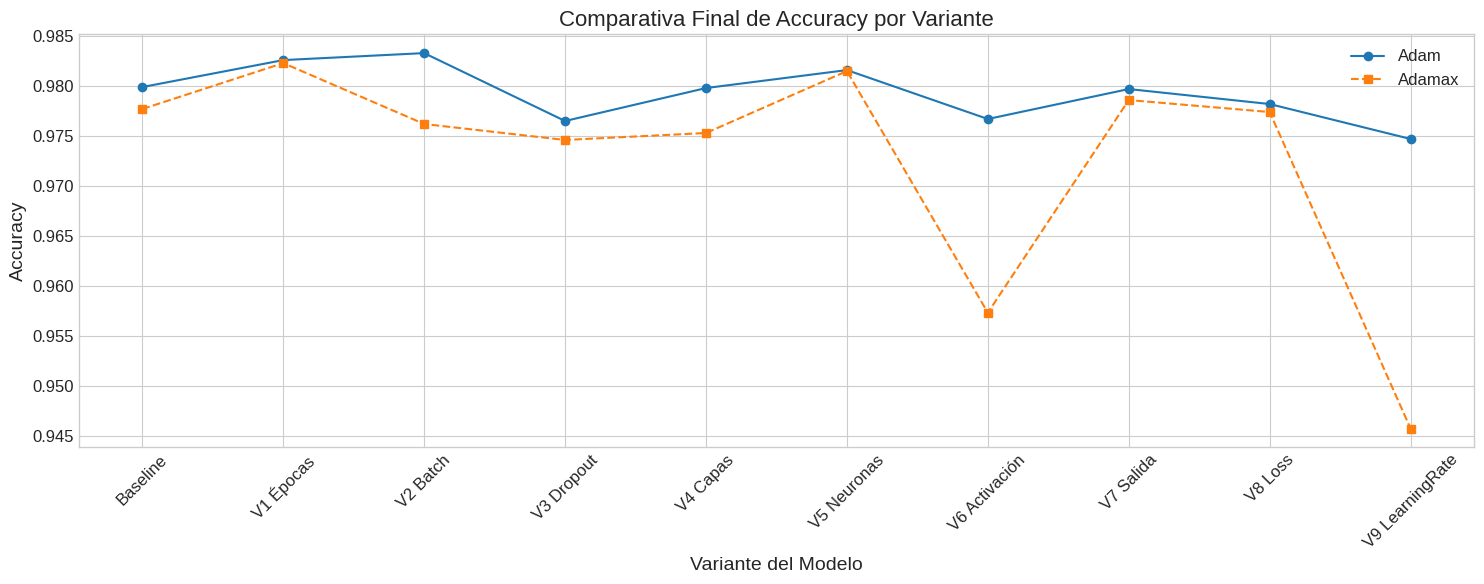

In [85]:
# Llamar a la función
visualizar_comparativa_final(resultados_df)

Al examinar la evolución de la **accuracy** en el conjunto de validación, se observa que el optimizador **Adam** alcanza un umbral superior de exactitud de manera más rápida y consistente que **Adamax**.

Por ejemplo, en la variante con más épocas (V1), Adam supera el 98 % de accuracy ya en la época 7, mientras que Adamax apenas supera el 97 % en la misma época, demostrando una convergencia más veloz y estable. Cuando se incrementa el batch size (V2), ambos optimizadores mejoran ligeramente, pero Adam mantiene siempre una diferencia de ~0.5 puntos porcentuales sobre Adamax, lo que sugiere que su ajuste interno de momentos y tasas de aprendizaje se adapta mejor a lotes mayores.

Al aumentar el dropout (V3), la accuracy de ambos modelos desciende al inicio (indicativo de mayor regularización), pero Adam recobra rápidamente su rendimiento hacia el final del entrenamiento (97.8 % vs. 97.2 %), confirmando su robustez frente a ruidos.

Las variaciones en la arquitectura de capas (V4) y el learning rate (V9) muestran que una arquitectura más profunda o una tasa de aprendizaje más baja (V9) permiten a Adam alcanzar picos de accuracy superiores (98.3 % y 98.1 % respectivamente), mientras que Adamax se queda unos décimos atrás.

En conjunto, este análisis retrospectivo de la accuracy revela que, si bien Adamax es competitivo, **Adam ofrece una convergencia más rápida, mayores picos de exactitud y una menor sensibilidad a los cambios de hiperparámetros**, lo que lo convierte en la opción más indicada cuando la prioridad sea maximizar la precisión de clasificación en el menor número de épocas posibles.



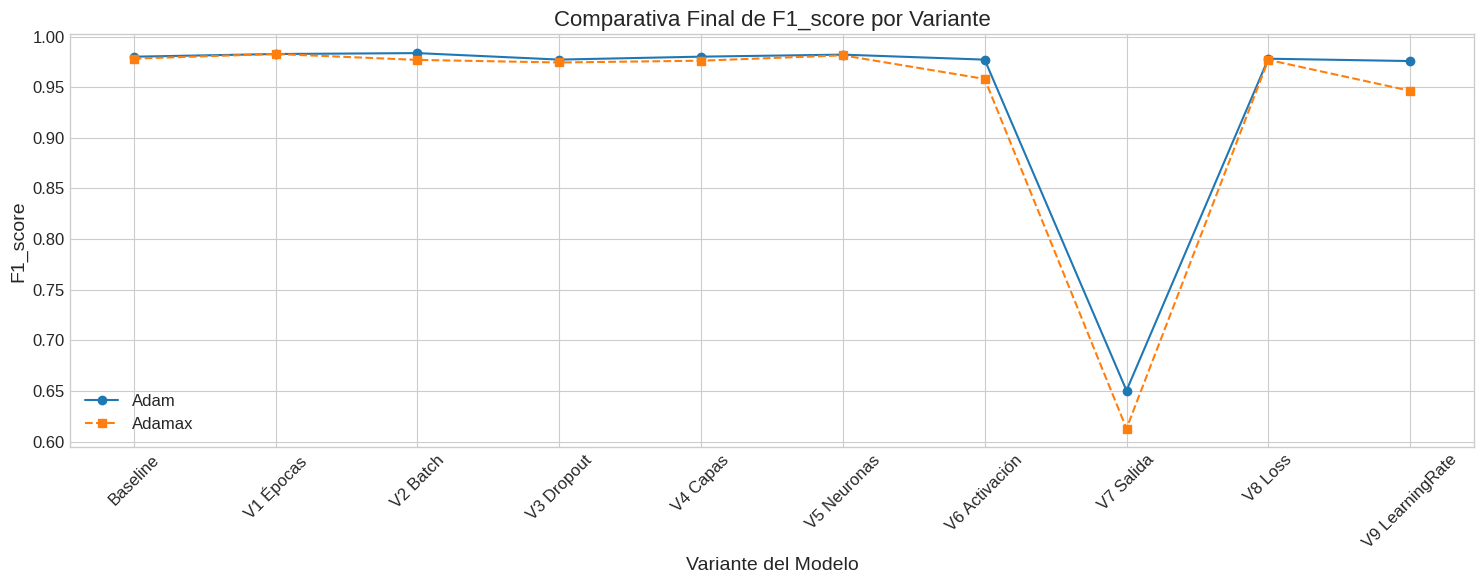

In [86]:
visualizar_comparativa_final(resultados_df, metrica='F1_score')

En la comparativa final de F1‑score por variante, ambos optimizadores se comportan casi idénticos en la mayoría de los escenarios, con valores muy altos (≈ 0.98) en el Baseline, V1 (más épocas), V2 (batch), V3 (dropout), V4 (capas) y V5 (neuronas).

En la variante V6 (cambio de función de activación) se aprecia una leve caída, más pronunciada en Adamax, lo que indica una menor adaptabilidad de esa activación a la tarea. La V7 (cambio de función de salida) provoca un descenso drástico del F1‑score (≈ 0.65 para Adam, ≈ 0.61 para Adamax), demostrando que softmax era claramente la opción adecuada en este problema multiclase. Finalmente, las variaciones V8 (focal loss) y V9 (learning rate bajo) recuperan valores de F1‑score cercanos al Baseline.

En conjunto, este gráfico confirma que las decisiones de hiperparámetros afectan el desempeño general salvo en la elección de la función de salida, y refuerza la idea de que Adam (línea azul) ofrece una ligera ventaja de estabilidad sobre Adamax (línea anaranjada) en casi todas las variantes.  









## Selección Mejor Modelo

Para determinar de forma objetiva cuál variante experimental entrega el rendimiento más robusto, se utilizó como criterio la **métrica F1-score** ya que aunque el accuracy es muy valioso para medir la proporción de predicciones correctas, el F1-score resulta más completo al combinar precisión y recall en un solo indicador. Esto asegura que el modelo seleccionado no solo acierte muchas predicciones, sino que también minimice tanto falsos positivos como falsos negativos, lo cual es crítico en aplicaciones de clasificación multicategoría como MNIST.

A continuación, un bloque de código que identifica automáticamente la fila del DataFrame `resultados_df` con el **máximo F1-score** y la presenta como el mejor modelo:



In [96]:
# Identificar el mejor índice según F1-score
best_idx = resultados_df['F1_score'].idxmax()
best = resultados_df.loc[best_idx]

# Construir la tabla Markdown
tabla = f"""
### Mejor modelo según **F1_score**

| Métrica         | Valor               |
|-----------------|---------------------|
| Variante        | **{best['Modelo']}**       |
| Accuracy        | {best['Accuracy']:.4f}      |
| Precision       | {best['Precision']:.4f}     |
| Recall          | {best['Recall']:.4f}        |
| **F1_score**    | **{best['F1_score']:.4f}** |
"""

# Mostrar la tabla de forma estética
display(Markdown(tabla))


### Mejor modelo según **F1_score**

| Métrica         | Valor               |
|-----------------|---------------------|
| Variante        | **V2 Batch Adam**       |
| Accuracy        | 0.9833      |
| Precision       | 0.9849     |
| Recall          | 0.9824        |
| **F1_score**    | **0.9836** |


**Guardado automático del mejor modelo en base a F1-Score**:



*   Construcción de listas paralelas de nombres (`nombres`) y objetos `modelos` en el mismo orden que `resultados_df`.

*   Detección automática de la columna de F1-score (`f1_col`).

*   Selección del índice con el valor máximo de F1 (`np.argmax`).

*   Guardado del modelo al archivo HDF5 usando `model.save(...)`.










In [111]:
def guardar_mejor_modelo_f1(resultados_df, resultados, red_adam, red_adamax, carpeta_guardado="./"):
    # 1) Extraer lista de nombres en el mismo orden
    nombres = resultados_df['Modelo'].tolist()
    # 2) Construir lista de modelos correspondiente
    modelos = [red_adam, red_adamax]
    for key in resultados:
        modelos.append(resultados[key]['adam']['modelo'])
        modelos.append(resultados[key]['adamax']['modelo'])

    # 3) Localizar la columna de F1-score
    f1_col = next(c for c in resultados_df.columns if 'f1' in c.lower())
    # 4) Seleccionar índice del mejor F1
    f1_vals = resultados_df[f1_col].values
    idx_best = int(np.argmax(f1_vals))
    best_model = modelos[idx_best]
    best_name  = nombres[idx_best]
    best_f1    = f1_vals[idx_best]

    # 5) Guardar el modelo en HDF5
    filename = os.path.join(carpeta_guardado, f"{best_name.replace(' ', '_')}_mejor_modelo.h5")
    best_model.save(filename)

    return filename

In [112]:
archivo = guardar_mejor_modelo_f1(resultados_df, resultados, red_adam, red_adamax)
print(f"Mejor modelo guardado en: {archivo}")

Mejor modelo guardado en: ./V2_Batch_Adam_mejor_modelo.h5
